In [1]:
import numpy as np
import matplotlib.pyplot as plt
import LISA_utils  # This is a python script full of nice tasty functions we can use for LISA (or LIGO) DA
import MS_func
import scipy
import scipy.signal
import scipy.constants
import os
from scipy import integrate

plt.rcParams['agg.path.chunksize'] = 10000

%load_ext autoreload
%autoreload 2

In [2]:
# Bunch of units

GM_sun = 1.3271244*1e20
c =2.9979246*1e8
M_sun =1.9884099*1e30
G = 6.6743*1e-11
pc= 3.0856776*1e16
pi = np.pi
Mpc = (10**6) * pc

In [3]:


def numerical_derivs(pars):
    logMchirp_1 = pars[0];eta_1 = pars[1];beta_1 = pars[2];
    logMchirp_2 = pars[0];eta_2 = pars[1];beta_2 = pars[2];
    
    
    logMchirp_delta = 1e-4
    params_1_p = [logMchirp_1 + logMchirp_delta,eta_1,beta_1,Deff_1]
    params_1_m = [logMchirp_1 - logMchirp_delta,eta_1,beta_1,Deff_1]

    deriv_log_Mchirp_1 = (htilde_AP(freq_bin,params_1_p) - htilde_AP(freq_bin,params_1_m))/(2*logMchirp_delta)


    eta_delta = 1e-6
    params_1_p = [logMchirp_1,eta_1 + eta_delta,beta_1,Deff_1]
    params_1_m = [logMchirp_1,eta_1 - eta_delta,beta_1,Deff_1]

    deriv_log_eta_1 = (htilde_AP(freq_bin,params_1_p) - htilde_AP(freq_bin,params_1_m))/(2*eta_delta)



    beta_delta = 1e-6
    params_1_p = [logMchirp_1,eta_1,beta_1 + beta_delta,Deff_1]
    params_1_m = [logMchirp_1,eta_1,beta_1 - beta_delta,Deff_1]

    deriv_log_beta_1 = (htilde_AP(freq_bin,params_1_p) - htilde_AP(freq_bin,params_1_m))/(2*beta_delta)

    diff_vec = [deriv_log_Mchirp_1,deriv_log_eta_1,deriv_log_beta_1]
    
    
    return diff_vec
    
    



In [48]:
"""
Signal parameters
"""

# Fix these two impostors, assume they are known perfectly.
# t0 =1.
# phi0 =0.
phi0 = np.pi/2
t0 = 2
fmin = 1e-4

# variables to sample through

#logDeff_true = np.log(10**2 *Mpc)

# Deff_1 = 3 * 1e3 * Mpc
# Deff_1 = 1*1e3*Mpc # good
# Deff_1 = 1.5e3 * Mpc
# Deff_1 = 1e3 * Mpc # Very good
Deff_1 = 2e3 * Mpc
beta_1 = 8
m1 = 8e6  
m2 = 4*1e6
M_tot_1 = (m1 + m2)  # M_tot in kilograms
eta_1 = (m1*m2)/(M_tot_1**2)  # Symmetric mass ratio [dimensionless]=
M_chirp_1 = M_tot_1*eta_1**(3/5)  # Chirp mass in units of kilograms 

f_max_1 = MS_func.final_frequency(M_chirp_1,eta_1)  # Calculate maximum frequency (Schwarzschild ISCO frequency)
t_max_1 = MS_func.T_chirp(fmin,M_chirp_1,eta_1)     # Calculate maximum chirping time that binary radiates stuff

# Deff_2 = 3*1*1e3 * Mpc #good
Deff_2 = 4e3 * Mpc

beta_2 = 7
m1 = 4*1e6  
m2 = 1*1e6
# m1 = 1.5*1e6  
# m2 = 1*1e6

M_tot_2 = (m1 + m2)  # M_tot in kilograms
eta_2 = (m1*m2)/(M_tot_2**2)  # Symmetric mass ratio [dimensionless]=
M_chirp_2 = M_tot_2*eta_2**(3/5)  # Chirp mass in units of kilograms 
print(eta_2)

f_max_2 = MS_func.final_frequency(M_chirp_2,eta_2)  # Calculate maximum frequency (Schwarzschild ISCO frequency)
t_max_2 = MS_func.T_chirp(fmin,M_chirp_2,eta_2)     # Calculate maximum chirping time that binary radiates stuff



logMchirp_1 = np.log(M_chirp_1)
logMchirp_2 = np.log(M_chirp_2)


pars_1 = [logMchirp_1,eta_1,beta_1,Deff_1] # array of parameters for waveform.
pars_2 = [logMchirp_2,eta_2,beta_2,Deff_2] # array of parameters for waveform.

# eps_GR = 4*1e-2
eps_GR = 1*1e-3

# Calculate max frequency and chirp time

fmax_min_sources = min(f_max_1,f_max_2)# Compute "smallest" largest frequency

tmax = max(t_max_1,t_max_2)  # Compute maximum chirping time for both binaries

print('Largest frequency',fmax_min_sources)
print('Final chirping time',tmax/60/60/24,'days')

delta_t = 1/(2*fmax_min_sources)         # Set sampling interval so that we can resolved frequencies of BOTH signals

t = np.arange(0,tmax,delta_t)     # Set up useless time vector
n_t = len(t)                      # Extract length

delta_f = 1/(n_t*delta_t)         # Extract sampling frequency

freq_bin = np.arange(fmin,fmax_min_sources,delta_f)     # Extract frequency series
n_f = len(freq_bin)                         # Extract length of frequency domain series

h_f_1 = MS_func.htilde_GR(freq_bin,eps_GR,pars_1)
h_f_2 = MS_func.htilde_GR(freq_bin,eps_GR,pars_2)


# h_f_approx = htilde_AP(freq_bin,pars)


# SNR

PSD = LISA_utils.PowerSpectralDensity(freq_bin)

SNR2_1 = MS_func.inner_prod(h_f_1,h_f_1,PSD,delta_f)
SNR2_2 = MS_func.inner_prod(h_f_2,h_f_2,PSD,delta_f)


print('SNR for source 1',np.sqrt(SNR2_1))
print('SNR for source 2',np.sqrt(SNR2_2))

print(eta_1,eta_2)

0.16
Largest frequency 0.00036643123198689786
Final chirping time 14.392200104590243 days
SNR for source 1 1850.9822700017835
SNR for source 2 378.61325122166954
0.2222222222222222 0.16


In [5]:
print(f_max_1,f_max_2)

0.00036643123198689786 0.0008794349567685549


In [6]:
# Numerical Derivatives - Source 1

diff_vec_1 = MS_func.numerical_derivs(freq_bin,pars_1)
diff_vec_2 = MS_func.numerical_derivs(freq_bin,pars_2)

diff_vec = diff_vec_1 + diff_vec_2

Cov_Matrix = MS_func.fish_matrix(diff_vec,PSD,delta_f)
Cov_Matrix_A = MS_func.fish_matrix(diff_vec_1,PSD,delta_f)
Cov_Matrix_B = MS_func.fish_matrix(diff_vec_2,PSD,delta_f)

In [7]:
# np.random.seed(123)
np.random.seed(140194)
# np.random.seed(150719)
# np.random.seed(10464)
variances = (PSD)/(4*delta_f)   # Variances (denominator of likelihood)

noise_1 = np.random.normal(0,np.sqrt(variances))
noise_2 = np.random.normal(0,np.sqrt(variances))

noise_f = noise_1 + 1j*noise_2

data_f = h_f_1 + h_f_2 + noise_f

In [8]:


Ntotal = 150000  # Number of iterations
burnin = 10000

logM_chirp_low = -100   # a prior bound (high)
logM_chirp_high = np.log(3e10)     # a prior bound (low)

eta_low = 0
eta_high = 0.25

beta_low = 0
beta_high = 9.4


true_vals = [np.log(M_chirp_1),eta_1,beta_1,
            np.log(M_chirp_2),eta_2,beta_2]  # True values to start chain with 

D_vec = [Deff_1,Deff_2]

# Run the algorithm
(logM_chirp_1_samps,eta_1_samps,beta_1_samps,
 logM_chirp_2_samps,eta_2_samps,beta_2_samps,lp) = MS_func.MCMC_full(data_f,
                                                   freq_bin, true_vals,D_vec,Cov_Matrix,
                                                   variances,
                                                   logM_chirp_high,logM_chirp_low,
                                                   eta_high,eta_low,
                                                   beta_high,beta_low,
                                                   Ntotal, 
                                                   burnin, 
                                                   printerval = 15000,
                                                   )

# Comparison:
h_f_1 = MS_func.htilde_GR(freq_bin,eps_GR,pars_1)
h_f_2 = MS_func.htilde_GR(freq_bin,eps_GR,pars_2)



# diff_vec_A = MS_func.numerical_derivs(freq_bin,pars_1)
# Cov_Matrix_A = MS_func.fish_matrix(diff_vec_A,PSD,delta_f)
        
# true_vals_A = [np.log(M_chirp_1),eta_1,beta_1]

# D_vec = [Deff_1]


# data_A = h_f_1
        
# logM_chirp_A_only,eta_A_only,beta_A_only,lp = MS_func.MCMC_1_sig(data_A,
#                                                    freq_bin, true_vals_A,D_vec,Cov_Matrix_A,
#                                                    variances,
#                                                    logM_chirp_high,logM_chirp_low,
#                                                    eta_high,eta_low,
#                                                    beta_high,beta_low,
#                                                    Ntotal, 
#                                                    burnin, 
#                                                    printerval = 25000,
#                                                    )

# diff_vec_B = MS_func.numerical_derivs(freq_bin,pars_2)
# Cov_Matrix_B = MS_func.fish_matrix(diff_vec_B,PSD,delta_f)
        
# true_vals_B = [np.log(M_chirp_2),eta_2,beta_2]

# D_vec = [Deff_2]


# data_B = h_f_2

# logM_chirp_B_only,eta_B_only,beta_B_only,lp = MS_func.MCMC_1_sig(data_B,
#                                                    freq_bin, true_vals_B,D_vec,Cov_Matrix_B,
#                                                    variances,
#                                                    logM_chirp_high,logM_chirp_low,
#                                                    eta_high,eta_low,
#                                                    beta_high,beta_low,
#                                                    Ntotal, 
#                                                    burnin, 
#                                                    printerval = 25000,
#                                                    )


# logM_chirp_1_samps = logM_chirp_1_samps[burnin:]
# eta_1_samps = eta_1_samps[burnin:]
# beta_1_samps = beta_1_samps[burnin:]

# logM_chirp_2_samps = logM_chirp_2_samps[burnin:]
# eta_2_samps = eta_2_samps[burnin:]
# beta_2_samps = beta_2_samps[burnin:]


# lp = lp[burnin:]

[1.40957878e-28 3.97800871e-29 3.32330688e-28 2.75829715e-27
 8.86553727e-28 2.18413359e-27 2.03935351e-27 1.92815940e-27
 1.88014190e-27 5.23108234e-28 1.03033928e-27 8.28948685e-28
 1.48012847e-27 2.27630437e-28 1.98137724e-28 1.09541819e-27
 3.85375468e-28 7.27911420e-28 1.67056157e-27 2.94856291e-28
 6.74718677e-28 1.92073269e-27 1.63136832e-28 8.25600419e-29
 2.55786036e-27 3.60102514e-28 4.90149767e-28 1.21434650e-27
 2.47537561e-28 2.35757097e-28 7.41258121e-29 2.72457031e-28
 2.73472728e-28 1.05713031e-27 4.86965249e-28 4.15388173e-29
 5.38348113e-28 2.87874556e-28 6.13218481e-28 5.81452602e-28
 1.02214609e-27 8.64790445e-28 3.89519696e-28 2.75360718e-29
 1.62067529e-28 4.89966495e-29 1.09370221e-28 2.24700612e-28
 2.07876557e-28 1.90944955e-28 9.99136715e-29 2.09073922e-28
 2.25494352e-29 2.11733301e-29 2.11772086e-28 1.30553437e-28
 3.33524972e-29 2.45071704e-28 8.52275492e-29 5.85136287e-29
 1.71571163e-28 2.97998602e-28 1.86874097e-28 1.32926950e-28
 2.04269649e-28 2.716148

In [9]:
print("Global Fit")
print("")
print("Source 1")
print('MCMC logM_chirp:',np.sqrt(np.var(logM_chirp_1_samps)))
print('MCMC eta:',np.sqrt(np.var(eta_1_samps)))
print('MCMC beta:',np.sqrt(np.var(beta_1_samps)))

print('FM: for source A taking correlations of B into account',np.sqrt(np.diag(Cov_Matrix)[0:3]))
print("")
print("Source 2")
print('MCMC logM_chirp:',np.sqrt(np.var(logM_chirp_2_samps)))
print('MCMC eta:',np.sqrt(np.var(eta_2_samps)))
print('MCMC beta:',np.sqrt(np.var(beta_2_samps)))
print('FM: for source B taking correlations of A into account',np.sqrt(np.diag(Cov_Matrix)[3:6]))
print("")
# print("Parameter estimation only on source 1 and 2. No Residuals")
# print("")
# print("If source 1 is only present")
# print('FM:',np.sqrt(np.diag(Cov_Matrix_A)[0:3]))
# print('MCMC logM_chirp:',np.sqrt(np.var(logM_chirp_A_only)))
# print('MCMC eta:',np.sqrt(np.var(eta_A_only)))
# print('MCMC beta:',np.sqrt(np.var(beta_A_only)))
# print("")
# print("If source 2 is only present")
# print('MCMC logM_chirp:',np.sqrt(np.var(logM_chirp_B_only)))
# print('MCMC eta:',np.sqrt(np.var(eta_B_only)))
# print('MCMC beta:',np.sqrt(np.var(beta_B_only)))
# print('FM:',np.sqrt(np.diag(Cov_Matrix_B)[0:3]))

Global Fit

Source 1
MCMC logM_chirp: 6.12318340164017e-05
MCMC eta: 0.0001004858699137552
MCMC beta: 0.0031780164191927474
FM: for source A taking correlations of B into account [6.10199228e-05 1.00302166e-04 3.17264780e-03]

Source 2
MCMC logM_chirp: 0.0006790637157796048
MCMC eta: 0.0020046103310291715
MCMC beta: 0.11712246658934558
FM: for source B taking correlations of A into account [0.00065047 0.00191454 0.11195714]



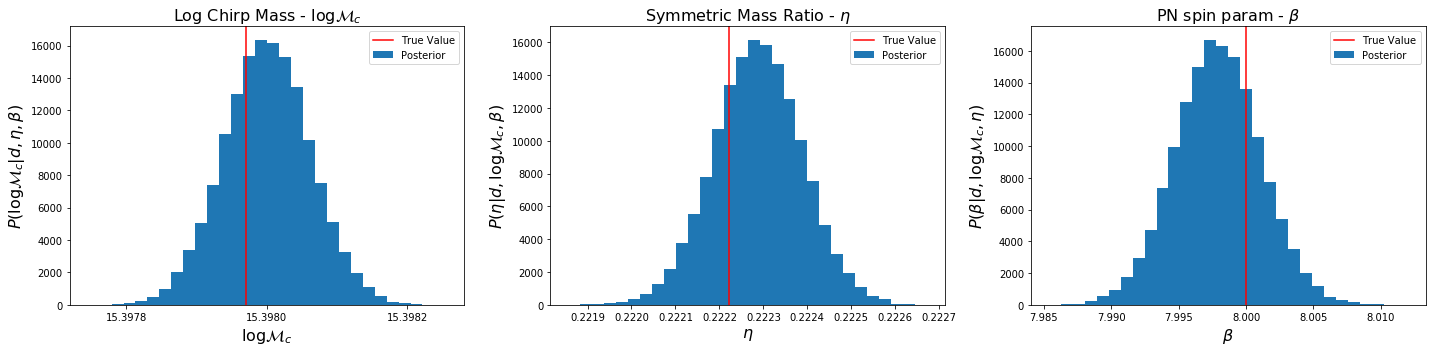

In [10]:
# Results

fig,ax = plt.subplots(1,3,figsize = (20,5))

ax[0].hist(logM_chirp_1_samps,bins = 30,label = 'Posterior')
ax[0].axvline(x = np.log(M_chirp_1),c = 'red', label = 'True Value')
# ax[0].axvline(x = a_res + a_bias, color = 'g', label = 'Predicted bias')
ax[0].set_xlabel(r'$\log \mathcal{M}_{c}$',fontsize = 16)
ax[0].set_ylabel(r'$P(\log \mathcal{M}_{c}|d,\eta,\beta)$',fontsize = 16)
ax[0].set_title(r'Log Chirp Mass - $\log \mathcal{M}_{c}$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[0].locator_params(axis='x', nbins=5)
ax[0].legend()
# ax[0].show()



ax[1].hist(eta_1_samps,bins = 30,label = 'Posterior')
ax[1].axvline(x = eta_1,c = 'red', label = 'True Value')
# ax[1].axvline(x = f_res + f0_bias, color = 'g', label = 'Predicted bias')
ax[1].set_xlabel(r'$\eta$',fontsize = 16)
ax[1].set_ylabel(r'$P(\eta|d,\log \mathcal{M}_{c},\beta)$',fontsize = 16)
ax[1].set_title(r'Symmetric Mass Ratio - $\eta$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[1].legend()
# ax[1].show()


ax[2].hist(beta_1_samps,bins = 30,label = 'Posterior')
ax[2].axvline(x = beta_1,c = 'red', label = 'True Value')
# ax[2].axvline(x = phi_res + phi_bias,c = 'g',label = 'Predicted bias' )
ax[2].set_xlabel(r'$\beta$',fontsize = 16)
ax[2].set_ylabel(r'$P(\beta|d,\log \mathcal{M}_{c},\eta)$',fontsize = 16)
ax[2].set_title(r'PN spin param - $\beta$',fontsize = 16)
ax[2].legend()
# ax[2].show()
plt.tight_layout()

In [11]:
# FM formalism
deltaH = 0
waveform_errors = (MS_func.htilde_GR(freq_bin,eps_GR,pars_1) - MS_func.htilde_AP(freq_bin,pars_1) + 
                   MS_func.htilde_GR(freq_bin,eps_GR,pars_2) - MS_func.htilde_AP(freq_bin,pars_2))

(biases_pred_n_gf, biases_pred_waveform_errors_gf,
 biases_pred_unresolved_gf,biases_pred_unresolved_total) = MS_func.CV_Calc(deltaH,noise_f,waveform_errors,diff_vec,Cov_Matrix,PSD,delta_f)

In [12]:
M_chirp_bias_1 = biases_pred_unresolved_total[0]
eta_bias_1 = biases_pred_unresolved_total[1]
beta_bias_1 = biases_pred_unresolved_total[2]

In [13]:
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

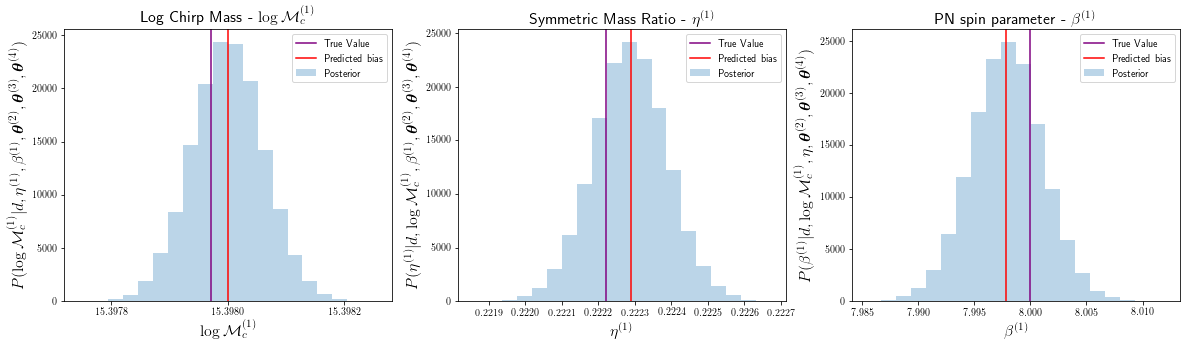

In [14]:
# Results

fig,ax = plt.subplots(1,3,figsize = (20,5))
alpha_val = 0.3

ax[0].hist(logM_chirp_1_samps,bins = 20,alpha = alpha_val,label = 'Posterior')
ax[0].axvline(x = np.log(M_chirp_1),color = 'purple',  label = 'True Value')
ax[0].axvline(x = np.log(M_chirp_1) + M_chirp_bias_1, color = 'red', label = 'Predicted bias')
ax[0].set_xlabel(r'$\log \mathcal{M}^{(1)}_{c}$',fontsize = 16)
ax[0].set_ylabel(r'$P(\log \mathcal{M}^{(1)}_{c}|d,\eta^{(1)},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[0].set_title(r'Log Chirp Mass - $\log \mathcal{M}^{(1)}_{c}$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[0].locator_params(axis='x', nbins=5)
ax[0].legend()
# ax[0].show()



ax[1].hist(eta_1_samps,bins = 20,alpha = alpha_val,label = 'Posterior')
ax[1].axvline(x = eta_1,c = 'purple', label = 'True Value')
ax[1].axvline(x = eta_1 + eta_bias_1, color = 'red', label = 'Predicted bias')
ax[1].set_xlabel(r'$\eta^{(1)}$',fontsize = 16)
ax[1].set_ylabel(r'$P(\eta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[1].set_title(r'Symmetric Mass Ratio - $\eta^{(1)}$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[1].legend()
# ax[1].show()


ax[2].hist(beta_1_samps,bins = 20,alpha = alpha_val,label = 'Posterior')
ax[2].axvline(x = beta_1,c = 'purple', label = 'True Value')
ax[2].axvline(x = beta_1 + beta_bias_1,c = 'red',label = 'Predicted bias' )
ax[2].set_xlabel(r'$\beta^{(1)}$',fontsize = 16)
ax[2].set_ylabel(r'$P(\beta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\eta,\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[2].set_title(r'PN spin parameter - $\beta^{(1)}$',fontsize = 16)
ax[2].legend()



In [15]:
diff_vec_A = MS_func.numerical_derivs(freq_bin,pars_1)

Cov_Matrix_A_g_B = MS_func.fish_matrix(diff_vec_A ,PSD,delta_f)
        
Ntotal = 200000
burnin = 10000
D_vec = [Deff_1]
        
logM_chirp_1_samps_A_g_B,eta_1_samps_A_g_B,beta_1_samps_A_g_B,lp = MS_func.MCMC_1_sig(data_f,
                                                   freq_bin, true_vals,D_vec,Cov_Matrix_A_g_B,
                                                   variances,
                                                   logM_chirp_high,logM_chirp_low,
                                                   eta_high,eta_low,
                                                   beta_high,beta_low,
                                                   Ntotal, 
                                                   burnin, 
                                                   printerval = 20000,
                                                   )



# Burnin
burnin = 10000

logM_chirp_1_samps_A_g_B = logM_chirp_1_samps_A_g_B[burnin:]
eta_1_samps_half_A_g_B = eta_1_samps_A_g_B[burnin:]
beta_1_samps_half_A_g_B = beta_1_samps_A_g_B[burnin:]


Prepare for bias
i =  20000
acceptance_reject ratio 45.8 percent
i =  40000
acceptance_reject ratio 45.69 percent
i =  60000
acceptance_reject ratio 45.81333333333333 percent
i =  80000
acceptance_reject ratio 45.69375 percent
i =  100000
acceptance_reject ratio 45.602 percent
i =  120000
acceptance_reject ratio 45.549166666666665 percent
i =  140000
acceptance_reject ratio 45.51857142857143 percent
i =  160000
acceptance_reject ratio 45.495 percent
i =  180000
acceptance_reject ratio 45.46277777777778 percent


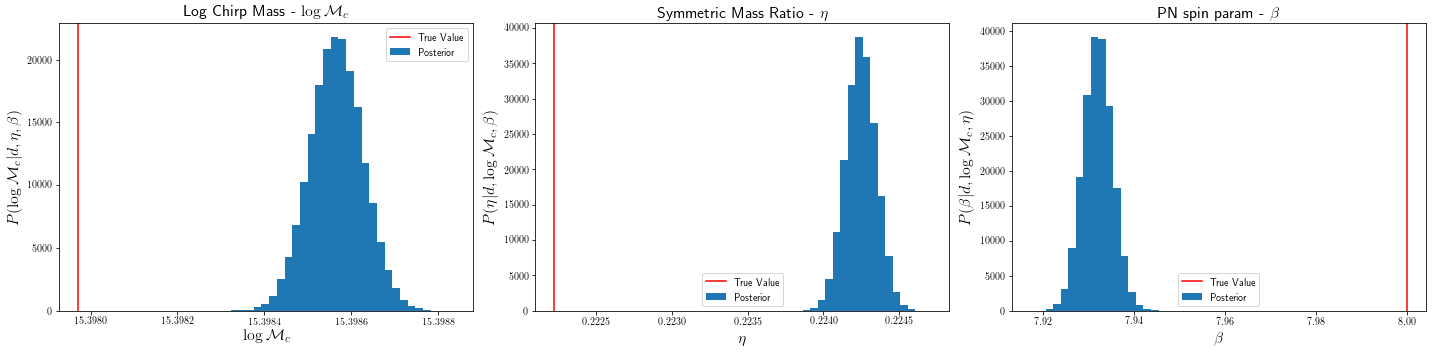

In [16]:
# Results

fig,ax = plt.subplots(1,3,figsize = (20,5))

ax[0].hist(logM_chirp_1_samps_A_g_B,bins = 30,label = 'Posterior')
ax[0].axvline(x = np.log(M_chirp_1),c = 'red', label = 'True Value')
# ax[0].axvline(x = a_res + a_bias, color = 'g', label = 'Predicted bias')
ax[0].set_xlabel(r'$\log \mathcal{M}_{c}$',fontsize = 16)
ax[0].set_ylabel(r'$P(\log \mathcal{M}_{c}|d,\eta,\beta)$',fontsize = 16)
ax[0].set_title(r'Log Chirp Mass - $\log \mathcal{M}_{c}$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[0].locator_params(axis='x', nbins=5)
ax[0].legend()
# ax[0].show()



ax[1].hist(eta_1_samps_A_g_B,bins = 50,label = 'Posterior')
ax[1].axvline(x = eta_1,c = 'red', label = 'True Value')
# ax[1].axvline(x = f_res + f0_bias, color = 'g', label = 'Predicted bias')
ax[1].set_xlabel(r'$\eta$',fontsize = 16)
ax[1].set_ylabel(r'$P(\eta|d,\log \mathcal{M}_{c},\beta)$',fontsize = 16)
ax[1].set_title(r'Symmetric Mass Ratio - $\eta$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[1].legend()
# ax[1].show()


ax[2].hist(beta_1_samps_A_g_B,bins = 50,label = 'Posterior')
ax[2].axvline(x = beta_1,c = 'red', label = 'True Value')
# ax[2].axvline(x = phi_res + phi_bias,c = 'g',label = 'Predicted bias' )
ax[2].set_xlabel(r'$\beta$',fontsize = 16)
ax[2].set_ylabel(r'$P(\beta|d,\log \mathcal{M}_{c},\eta)$',fontsize = 16)
ax[2].set_title(r'PN spin param - $\beta$',fontsize = 16)
ax[2].legend()
# ax[2].show()
plt.tight_layout()


In [17]:
# Fails, try something else. Sort out the derivatives

# Numerical Derivatives - Source 1

logM_chirp_1_samps_mean = np.mean(logM_chirp_1_samps_A_g_B)
eta_1_samps_mean = np.mean(eta_1_samps_A_g_B)
beta_1_samps_mean = np.mean(beta_1_samps_A_g_B)

pars_1_bf = [logM_chirp_1_samps_mean , eta_1_samps_mean, beta_1_samps_mean,Deff_1]

diff_vec_A_g_B_bf = MS_func.numerical_derivs(freq_bin,pars_1_bf)
Cov_Matrix_A_g_B_bf = MS_func.fish_matrix(diff_vec_A_g_B_bf,PSD,delta_f)

In [18]:
print('Fish',np.sqrt(np.diag(Cov_Matrix_A_g_B_bf))[0:3])
print('LogMc sd',np.sqrt(np.var(logM_chirp_1_samps_A_g_B)))
print('eta sd',np.sqrt(np.var(eta_1_samps_A_g_B)))
print('beta sd',np.sqrt(np.var(beta_1_samps_A_g_B)))

Fish [6.06363989e-05 1.02385817e-04 3.24543706e-03]
LogMc sd 6.0891171127096506e-05
eta sd 0.00010479178760615204
beta sd 0.003324927727779807


In [19]:
# FM formalism

deltaH = MS_func.htilde_GR(freq_bin,eps_GR,pars_2)
waveform_errors = (MS_func.htilde_GR(freq_bin,eps_GR,pars_1) - MS_func.htilde_AP(freq_bin,pars_1))
deltah = noise_f + waveform_errors + deltaH

(biases_pred_n_A_bf,
  biases_pred_waveform_errors_A_bf,
  biases_pred_unresolved_A_bf, 
  biases_pred_unresolved_total_sig_2_A_bf) = MS_func.CV_Calc(deltaH,noise_f,waveform_errors,
                                     diff_vec_A_g_B_bf,Cov_Matrix_A_g_B_bf,PSD,delta_f)


In [20]:
M_chirp_bias_1_first_A_bf = biases_pred_unresolved_total_sig_2_A_bf[0]
eta_bias_1_first_A_bf = biases_pred_unresolved_total_sig_2_A_bf[1]
beta_bias_1_first_A_bf = biases_pred_unresolved_total_sig_2_A_bf[2]

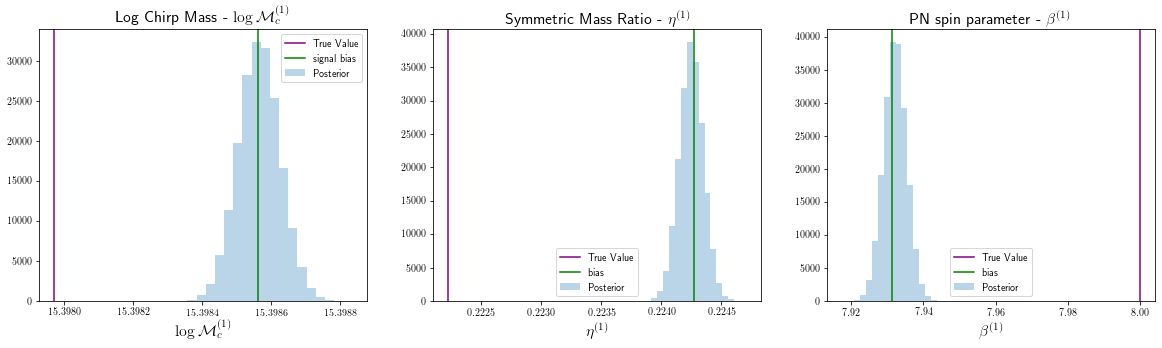

In [21]:
# Results

fig,ax = plt.subplots(1,3,figsize = (20,5))
alpha_val = 0.3

ax[0].hist(logM_chirp_1_samps_A_g_B,bins = 20,alpha = alpha_val,label = 'Posterior')
ax[0].axvline(x = np.log(M_chirp_1),color = 'purple',  label = 'True Value')
ax[0].axvline(x = np.log(M_chirp_1) + M_chirp_bias_1_first_A_bf,c = 'green',label = 'signal bias' )
ax[0].set_xlabel(r'$\log \mathcal{M}^{(1)}_{c}$',fontsize = 16)
# ax[0].set_ylabel(r'$P(\log \mathcal{M}^{(1)}_{c}|d,\eta^{(1)},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[0].set_title(r'Log Chirp Mass - $\log \mathcal{M}^{(1)}_{c}$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[0].locator_params(axis='x', nbins=5)
ax[0].legend()
# ax[0].show()



ax[1].hist(eta_1_samps_A_g_B,bins = 50,alpha = alpha_val,label = 'Posterior')
ax[1].axvline(x = eta_1,c = 'purple', label = 'True Value')
ax[1].axvline(x = eta_1 + eta_bias_1_first_A_bf,c = 'green',label = 'bias' )
ax[1].set_xlabel(r'$\eta^{(1)}$',fontsize = 16)
# ax[1].set_ylabel(r'$P(\eta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[1].set_title(r'Symmetric Mass Ratio - $\eta^{(1)}$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[1].legend()
# ax[1].show()


ax[2].hist(beta_1_samps_A_g_B,bins = 50,alpha = alpha_val,label = 'Posterior')
ax[2].axvline(x = beta_1,c = 'purple', label = 'True Value')
ax[2].axvline(x = beta_1 + beta_bias_1_first_A_bf,c = 'green',label = 'bias' )
ax[2].set_xlabel(r'$\beta^{(1)}$',fontsize = 16)
# ax[2].set_ylabel(r'$P(\beta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\eta,\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[2].set_title(r'PN spin parameter - $\beta^{(1)}$',fontsize = 16)
ax[2].legend()





In [22]:
# Form new data stream

h_f_1_bf = MS_func.htilde_AP(freq_bin,pars_1_bf)

new_data_f = data_f - (h_f_1_bf)  # Formed new data set with only "two fitted signals".

residual_1 = (h_f_1 - h_f_1_bf) 
SNR_residual = np.sqrt(MS_func.inner_prod(residual_1,residual_1,PSD,delta_f))
print(SNR_residual)



24.81055187771731


In [23]:
diff_vec_B = MS_func.numerical_derivs(freq_bin,pars_2)
Cov_Matrix_B = MS_func.fish_matrix(diff_vec_B,PSD,delta_f)
        
true_vals_B = [np.log(M_chirp_2),eta_2,beta_2]

D_vec = [Deff_2]
Ntotal = 100000
        
logM_chirp_2_samps_B_g_A_res,eta_2_samps_B_g_A_res,beta_2_samps_B_g_A_res,lp = MS_func.MCMC_1_sig(new_data_f,
                                                   freq_bin, true_vals_B,D_vec,Cov_Matrix_B,
                                                   variances,
                                                   logM_chirp_high,logM_chirp_low,
                                                   eta_high,eta_low,
                                                   beta_high,beta_low,
                                                   Ntotal, 
                                                   burnin, 
                                                   printerval = 25000,
                                                   )







Prepare for bias
i =  25000
acceptance_reject ratio 41.524 percent
i =  50000
acceptance_reject ratio 41.444 percent
i =  75000
acceptance_reject ratio 41.284 percent


In [24]:
# Burnin
burnin = 10000

logM_chirp_2_samps_B_A_res = logM_chirp_2_samps_B_g_A_res[burnin:]
eta_2_samps_B_A_res = eta_2_samps_B_g_A_res[burnin:]
beta_2_samps_B_A_res = beta_2_samps_B_g_A_res[burnin:]


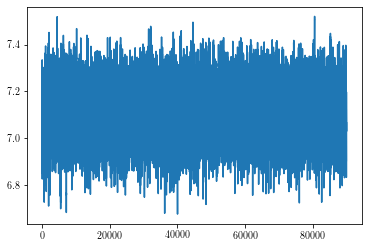

In [25]:
plt.plot(beta_2_samps_B_A_res)

In [26]:
logM_chirp_2_samps_mean = np.median(logM_chirp_2_samps_B_A_res)
eta_2_samps_mean = np.median(eta_2_samps_B_A_res)
beta_2_samps_mean = np.median(beta_2_samps_B_A_res)

pars_2_bf = [logM_chirp_2_samps_mean , eta_2_samps_mean, beta_2_samps_mean,Deff_2]
diff_vec_B_g_A_res_bf = MS_func.numerical_derivs(freq_bin,pars_2_bf)
Cov_Matrix_B_g_A_res_bf = MS_func.fish_matrix(diff_vec_B_g_A_res_bf,PSD,delta_f)

In [27]:
print(np.sqrt(np.diag(Cov_Matrix_B_g_A_res_bf)))
print(np.sqrt(np.var(logM_chirp_2_samps_B_A_res)))
print(np.sqrt(np.var(eta_2_samps_B_A_res)))
print(np.sqrt(np.var(beta_2_samps_B_A_res)))


[0.00061413 0.00178626 0.10488312]
0.0006433609933427187
0.0018730156161292431
0.10993953001017757


In [28]:
# Can I predict the above bias?

deltaH = residual_1 

waveform_errors = (MS_func.htilde_GR(freq_bin,eps_GR,pars_2) - MS_func.htilde_AP(freq_bin,pars_2))

deltah = noise_f + waveform_errors + deltaH

(biases_pred_n_B_bf,
 biases_pred_waveform_errors_B_bf,
 biases_pred_unresolved_B_bf, 
 biases_pred_unresolved_total_sig_1_B_bf) = MS_func.CV_Calc(deltaH,noise_f,waveform_errors,
                                     diff_vec_B_g_A_res_bf,Cov_Matrix_B_g_A_res_bf,PSD,delta_f)

In [29]:
M_chirp_bias_B_A_res = biases_pred_unresolved_total_sig_1_B_bf[0]
eta_bias_B_A_res = biases_pred_unresolved_total_sig_1_B_bf[1]
beta_bias_B_A_res = biases_pred_unresolved_total_sig_1_B_bf[2]

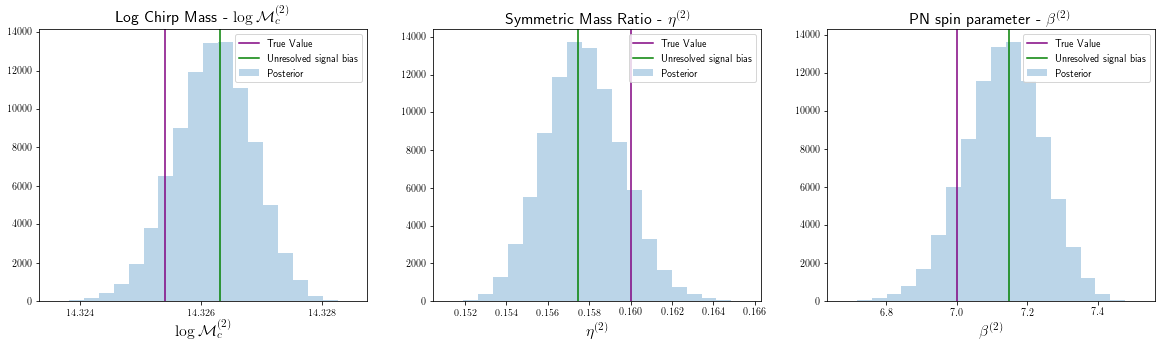

In [30]:
# Results

fig,ax = plt.subplots(1,3,figsize = (20,5))
alpha_val = 0.3

ax[0].hist(logM_chirp_2_samps_B_A_res,bins = 20,alpha = alpha_val,label = 'Posterior')
ax[0].axvline(x = np.log(M_chirp_2) ,color = 'purple',  label = 'True Value')
ax[0].axvline(x = np.log(M_chirp_2) + biases_pred_unresolved_B_bf[0],c = 'green',label = 'Unresolved  signal bias' )
ax[0].set_xlabel(r'$\log \mathcal{M}^{(2)}_{c}$',fontsize = 16)
# ax[0].set_ylabel(r'$P(\log \mathcal{M}^{(1)}_{c}|d,\eta^{(1)},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[0].set_title(r'Log Chirp Mass - $\log \mathcal{M}^{(2)}_{c}$',fontsize = 16)
# ax[0].set_xlim([np.log(M_chirp_3) - 10*np.sqrt(Cov_Matrix_half_2_bf[0,0]),np.log(M_chirp_3) + 5*np.sqrt(Cov_Matrix_half_2_bf[0,0])])
ax[0].locator_params(axis='x', nbins=5)
ax[0].legend()
# ax[0].show()



ax[1].hist(eta_2_samps_B_A_res,bins = 20,alpha = alpha_val,label = 'Posterior')
ax[1].axvline(x = eta_2,c = 'purple', label = 'True Value')
ax[1].axvline(x = eta_2 + biases_pred_unresolved_B_bf[1],c = 'green',label = 'Unresolved signal bias' )
ax[1].set_xlabel(r'$\eta^{(2)}$',fontsize = 16)
# ax[1].set_ylabel(r'$P(\eta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[1].set_title(r'Symmetric Mass Ratio - $\eta^{(2)}$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[1].legend()
# ax[1].show()


ax[2].hist(beta_2_samps_B_A_res,bins = 20,alpha = alpha_val,label = 'Posterior')
ax[2].axvline(x = beta_2,c = 'purple', label = 'True Value')
ax[2].axvline(x = beta_2 + biases_pred_unresolved_B_bf[2],c = 'green',label = 'Unresolved signal bias' )
ax[2].set_xlabel(r'$\beta^{(2)}$',fontsize = 16)
# ax[2].set_ylabel(r'$P(\beta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\eta,\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[2].set_title(r'PN spin parameter - $\beta^{(2)}$',fontsize = 16)
ax[2].legend()







In [31]:
# First iteration :

pars_A_g_B_0 = [logM_chirp_1_samps_mean , eta_1_samps_mean, beta_1_samps_mean,Deff_1]
pars_B_g_A_res_0 = [logM_chirp_2_samps_mean , eta_2_samps_mean, beta_2_samps_mean,Deff_2]

# What is best guess of A_g_B_res parameters without doing A|B_res PE?

# Compute derivatives \partial h_{1} at parameters A|B

diff_vec_A_g_B_0 = MS_func.numerical_derivs(freq_bin,pars_A_g_B_0)
Cov_Matrix_A_g_B_0 = MS_func.fish_matrix(diff_vec_A_g_B_0,PSD,delta_f)



# deltaH_B = h_f_2 - MS_func.htilde_AP(freq_bin,pars_B_g_A_res_0)  # Old residual
deltaH_B = MS_func.htilde_AP(freq_bin,pars_B_g_A_res_0)   # New residual
delta_h_B = deltaH_B #+ noise_f
print('SNR of residuals',np.sqrt(MS_func.inner_prod(deltaH_B,deltaH_B,PSD,delta_f)))

b_vec_A_g_B_0 = [MS_func.inner_prod(diff_vec_A_g_B_0[i],delta_h_B,PSD,delta_f) for i in range(0,3)]

new_biases_A_g_B_0 = np.matmul(Cov_Matrix_A_g_B_0,b_vec_A_g_B_0)

# These are new biases on A|B parameters given smaller residuals

# Parameters A given B_residuals fromm last iteration

logM_chirp_1_A_g_B_1 = np.mean(logM_chirp_1_samps_A_g_B) - new_biases_A_g_B_0[0]
eta_1_samps_A_g_B_1 = np.mean(eta_1_samps_A_g_B) - new_biases_A_g_B_0[1]
beta_1_samps_A_g_B_1 = np.mean(beta_1_samps_A_g_B) - new_biases_A_g_B_0[2]

# New parameters
pars_A_g_B_res_1 = [logM_chirp_1_A_g_B_1, eta_1_samps_A_g_B_1, beta_1_samps_A_g_B_1, Deff_1]

# Old parameters B|A_res_0

pars_B_g_A_res_0 = [logM_chirp_2_samps_mean , eta_2_samps_mean, beta_2_samps_mean,Deff_2]

# Algorithm again


diff_vec_B_g_A_0_bf = MS_func.numerical_derivs(freq_bin,pars_B_g_A_res_0)  

Cov_Matrix_B_g_A_0_bf = MS_func.fish_matrix(diff_vec_B_g_A_0_bf,PSD,delta_f)

# Calculate residual in data stream - TRUE SIGNAL - TRUE SIGNAL_params A given B_res.


deltaH_A = MS_func.htilde_AP(freq_bin,pars_A_g_B_res_1)  - MS_func.htilde_AP(freq_bin,pars_A_g_B_0) + noise_f
deltah_A = deltaH_A# + noise_f

b_vec_B_g_A_0 = [MS_func.inner_prod(diff_vec_B_g_A_0_bf[i],
                                               deltah_A,PSD,delta_f) for i in range(0,3)]

new_biases_B_g_A_0 = np.matmul(Cov_Matrix_B_g_A_0_bf,
                                                b_vec_B_g_A_0)




# These are new biases on B|A parameters given smaller residuals

SNR of residuals 378.87265286749323


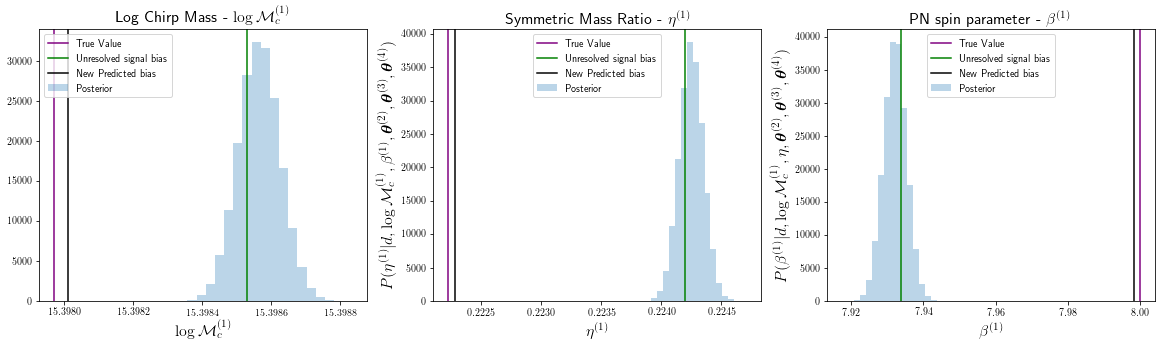

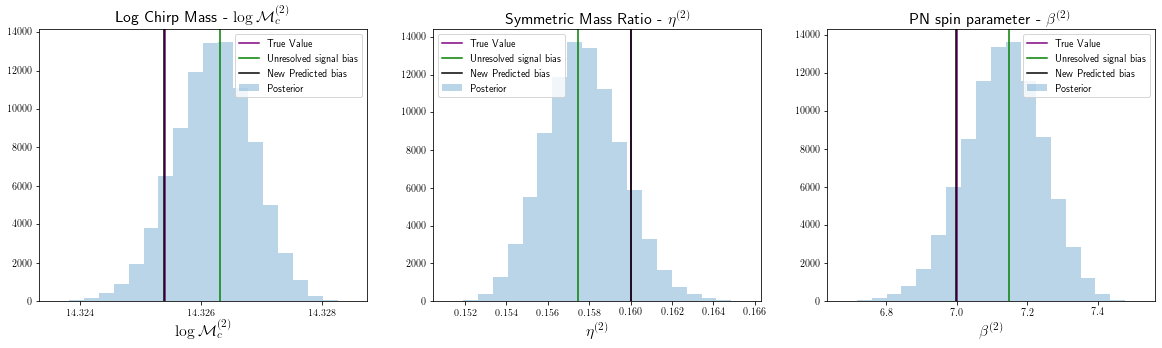

In [32]:
# Results

fig,ax = plt.subplots(1,3,figsize = (20,5))
alpha_val = 0.3

ax[0].hist(logM_chirp_1_samps_A_g_B,bins = 20,alpha = alpha_val,label = 'Posterior')
ax[0].axvline(x = np.log(M_chirp_1),color = 'purple',  label = 'True Value')
ax[0].axvline(x = np.log(M_chirp_1) + biases_pred_unresolved_A_bf[0],c = 'green',label = 'Unresolved  signal bias' )
ax[0].axvline(x = np.mean(logM_chirp_1_samps_A_g_B) - new_biases_A_g_B_0[0], color = 'k', label = 'New Predicted bias')
ax[0].set_xlabel(r'$\log \mathcal{M}^{(1)}_{c}$',fontsize = 16)
# ax[0].set_ylabel(r'$P(\log \mathcal{M}^{(1)}_{c}|d,\eta^{(1)},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[0].set_title(r'Log Chirp Mass - $\log \mathcal{M}^{(1)}_{c}$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[0].locator_params(axis='x', nbins=5)
ax[0].legend()
# ax[0].show()



ax[1].hist(eta_1_samps_A_g_B,bins = 50,alpha = alpha_val,label = 'Posterior')
ax[1].axvline(x = eta_1,c = 'purple', label = 'True Value')
ax[1].axvline(x = eta_1 + biases_pred_unresolved_A_bf[1],c = 'green',label = 'Unresolved signal bias' )
ax[1].axvline(x = np.mean(eta_1_samps_A_g_B) - new_biases_A_g_B_0[1], color = 'k', label = 'New Predicted bias')
ax[1].set_xlabel(r'$\eta^{(1)}$',fontsize = 16)
ax[1].set_ylabel(r'$P(\eta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[1].set_title(r'Symmetric Mass Ratio - $\eta^{(1)}$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[1].legend()
# ax[1].show()


ax[2].hist(beta_1_samps_A_g_B,bins = 50,alpha = alpha_val,label = 'Posterior')
ax[2].axvline(x = beta_1,c = 'purple', label = 'True Value')
ax[2].axvline(x = beta_1 + biases_pred_unresolved_A_bf[2],c = 'green',label = 'Unresolved signal bias' )
ax[2].axvline(x = np.mean(beta_1_samps_A_g_B) - new_biases_A_g_B_0[2], color = 'k', label = 'New Predicted bias')
ax[2].set_xlabel(r'$\beta^{(1)}$',fontsize = 16)
ax[2].set_ylabel(r'$P(\beta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\eta,\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[2].set_title(r'PN spin parameter - $\beta^{(1)}$',fontsize = 16)
ax[2].legend()




# Results

fig,ax = plt.subplots(1,3,figsize = (20,5))
alpha_val = 0.3

ax[0].hist(logM_chirp_2_samps_B_A_res,bins = 20,alpha = alpha_val,label = 'Posterior')
ax[0].axvline(x = np.log(M_chirp_2) ,color = 'purple',  label = 'True Value')
ax[0].axvline(x = np.log(M_chirp_2) + biases_pred_unresolved_B_bf[0],c = 'green',label = 'Unresolved  signal bias' )
ax[0].axvline(x = np.mean(logM_chirp_2_samps_B_A_res) - new_biases_B_g_A_0[0], color = 'k', label = 'New Predicted bias')
ax[0].set_xlabel(r'$\log \mathcal{M}^{(2)}_{c}$',fontsize = 16)
# ax[0].set_ylabel(r'$P(\log \mathcal{M}^{(1)}_{c}|d,\eta^{(1)},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[0].set_title(r'Log Chirp Mass - $\log \mathcal{M}^{(2)}_{c}$',fontsize = 16)
# ax[0].set_xlim([np.log(M_chirp_3) - 10*np.sqrt(Cov_Matrix_half_2_bf[0,0]),np.log(M_chirp_3) + 5*np.sqrt(Cov_Matrix_half_2_bf[0,0])])
ax[0].locator_params(axis='x', nbins=5)
ax[0].legend()
# ax[0].show()



ax[1].hist(eta_2_samps_B_A_res,bins = 20,alpha = alpha_val,label = 'Posterior')
ax[1].axvline(x = eta_2,c = 'purple', label = 'True Value')
ax[1].axvline(x = eta_2 + biases_pred_unresolved_B_bf[1],c = 'green',label = 'Unresolved signal bias' )
ax[1].axvline(x = np.mean(eta_2_samps_B_A_res) - new_biases_B_g_A_0[1], color = 'k', label = 'New Predicted bias')
ax[1].set_xlabel(r'$\eta^{(2)}$',fontsize = 16)
# ax[1].set_ylabel(r'$P(\eta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[1].set_title(r'Symmetric Mass Ratio - $\eta^{(2)}$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[1].legend()
# ax[1].show()


ax[2].hist(beta_2_samps_B_A_res,bins = 20,alpha = alpha_val,label = 'Posterior')
ax[2].axvline(x = beta_2,c = 'purple', label = 'True Value')
ax[2].axvline(x = beta_2 + biases_pred_unresolved_B_bf[2],c = 'green',label = 'Unresolved signal bias' )
ax[2].axvline(x = np.mean(beta_2_samps_B_A_res) - new_biases_B_g_A_0[2], color = 'k', label = 'New Predicted bias')
ax[2].set_xlabel(r'$\beta^{(2)}$',fontsize = 16)
# ax[2].set_ylabel(r'$P(\beta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\eta,\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[2].set_title(r'PN spin parameter - $\beta^{(2)}$',fontsize = 16)
ax[2].legend()









In [33]:
# Iteration 1 - B_g_A_res_1

logM_chirp_2_B_g_A_1 = np.mean(logM_chirp_2_samps_B_A_res) - new_biases_B_g_A_0[0]
eta_2_B_g_A_1 = np.mean(eta_2_samps_B_A_res) - new_biases_B_g_A_0[1]
beta_2_B_g_A_1 = np.mean(beta_2_samps_B_A_res) - new_biases_B_g_A_0[2]

pars_B_g_A_res_1 = [logM_chirp_2_B_g_A_1,eta_2_B_g_A_1,beta_2_B_g_A_1,Deff_2]

# Iteration 1 - A_g_B_res

diff_vec_A_g_B_1_bf = MS_func.numerical_derivs(freq_bin,pars_A_g_B_res_1)  
        
Cov_Matrix_A_g_B_1_bf = MS_func.fish_matrix(diff_vec_A_g_B_1_bf,PSD,delta_f)

deltaH_A_g_B_1 = MS_func.htilde_AP(freq_bin,pars_B_g_A_res_1)
deltah_A_g_B_1 = deltaH_A_g_B_1 #+ noise_f 

print('SNR of residuals',np.sqrt(MS_func.inner_prod(deltaH_A_g_B_1,deltaH_A_g_B_1,PSD,delta_f)))

b_vec_A_g_B_1 = [MS_func.inner_prod(diff_vec_A_g_B_1_bf[i],deltah_A_g_B_1,
                                               PSD,delta_f) for i in range(0,3)]

new_biases_A_g_B_1 = np.matmul(Cov_Matrix_A_g_B_1_bf,
                                                  b_vec_A_g_B_1)

# Update

pars_A_g_B_res_2 = [np.mean(logM_chirp_1_samps_A_g_B) - new_biases_A_g_B_1[0],
                    np.mean(eta_1_samps_A_g_B) - new_biases_A_g_B_1[1],
                    np.mean(beta_1_samps_A_g_B) - new_biases_A_g_B_1[2],
                    Deff_1]


pars_B_g_A_res_1 = [np.mean(logM_chirp_2_samps_B_A_res) - new_biases_B_g_A_0[0],
                    np.mean(eta_2_samps_B_A_res) - new_biases_B_g_A_0[1],
                   np.mean(beta_2_samps_B_A_res) - new_biases_B_g_A_0[2],Deff_2]

# Algorithm again


diff_vec_B_g_A_1_bf = MS_func.numerical_derivs(freq_bin,pars_B_g_A_res_1)  

Cov_Matrix_B_g_A_1_bf = MS_func.fish_matrix(diff_vec_B_g_A_1_bf,PSD,delta_f)

# Calculate residual in data stream - TRUE SIGNAL - TRUE SIGNAL_params A given B_res.

deltaH_B_g_A_1 = MS_func.htilde_AP(freq_bin,pars_A_g_B_res_2) - MS_func.htilde_AP(freq_bin,pars_A_g_B_res_1)  

deltah_B_g_A_1 =  deltaH_B_g_A_1 #+ noise_f

b_vec_B_g_A_1 = [MS_func.inner_prod(diff_vec_B_g_A_1_bf[i],
                                               deltah_B_g_A_1,PSD,delta_f) for i in range(0,3)]

new_biases_B_g_A_1 = np.matmul(Cov_Matrix_B_g_A_1_bf,
                                                b_vec_B_g_A_1)

biases_B_g_A_res_2 = [pars_B_g_A_res_1[i] - new_biases_B_g_A_1[i] for i in range(0,3)]



SNR of residuals 378.6103912175943


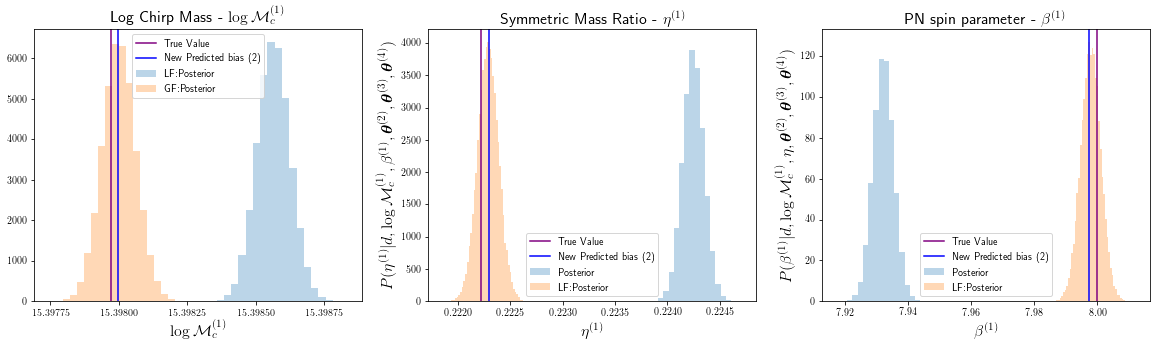

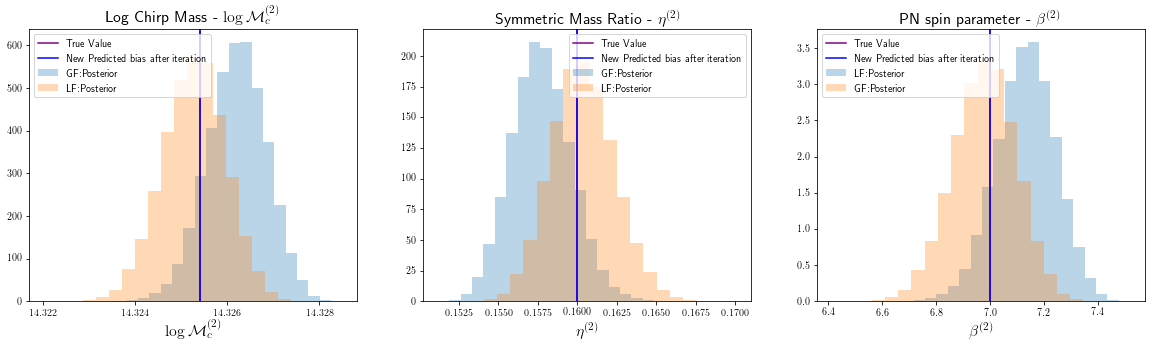

In [34]:
# Results

fig,ax = plt.subplots(1,3,figsize = (20,5))
alpha_val = 0.3

ax[0].hist(logM_chirp_1_samps_A_g_B,density=True,bins = 20,alpha = alpha_val,label = 'LF:Posterior')
ax[0].hist(logM_chirp_1_samps,density=True,bins = 20,alpha = alpha_val,label = 'GF:Posterior')
ax[0].axvline(x = np.log(M_chirp_1),color = 'purple',  label = 'True Value')
# ax[0].axvline(x = np.log(M_chirp_1) + biases_pred_unresolved_A_bf[0],c = 'green',label = 'Unresolved  signal bias' )
# ax[0].axvline(x = np.mean(logM_chirp_1_samps_A_g_B) - new_biases_A_g_B_0[0], color = 'k', label = 'New Predicted bias (1)')
ax[0].axvline(x = pars_A_g_B_res_2[0], color = 'blue', label = 'New Predicted bias (2)')
ax[0].set_xlabel(r'$\log \mathcal{M}^{(1)}_{c}$',fontsize = 16)
# ax[0].set_ylabel(r'$P(\log \mathcal{M}^{(1)}_{c}|d,\eta^{(1)},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[0].set_title(r'Log Chirp Mass - $\log \mathcal{M}^{(1)}_{c}$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[0].locator_params(axis='x', nbins=5)
ax[0].legend()
# ax[0].show()



ax[1].hist(eta_1_samps_A_g_B,density=True,bins = 50,alpha = alpha_val,label = 'Posterior')
ax[1].hist(eta_1_samps,density=True,bins = 50,alpha = alpha_val,label = 'LF:Posterior')
ax[1].axvline(x = eta_1,c = 'purple', label = 'True Value')
# ax[1].axvline(x = eta_1 + biases_pred_unresolved_A_bf[1],c = 'green',label = 'Unresolved signal bias' )
# ax[1].axvline(x = np.mean(eta_1_samps_A_g_B) - new_biases_A_g_B_0[1], color = 'k', label = 'New Predicted bias')
ax[1].axvline(x = pars_A_g_B_res_2[1], color = 'blue', label = 'New Predicted bias (2)')
ax[1].set_xlabel(r'$\eta^{(1)}$',fontsize = 16)
ax[1].set_ylabel(r'$P(\eta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[1].set_title(r'Symmetric Mass Ratio - $\eta^{(1)}$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[1].legend()
# ax[1].show()


ax[2].hist(beta_1_samps_A_g_B,density=True,bins = 50,alpha = alpha_val,label = 'Posterior')
ax[2].hist(beta_1_samps,density=True,bins = 50,alpha = alpha_val,label = 'LF:Posterior')
ax[2].axvline(x = beta_1,c = 'purple', label = 'True Value')
# ax[2].axvline(x = beta_1 + biases_pred_unresolved_A_bf[2],c = 'green',label = 'Unresolved signal bias' )
# ax[2].axvline(x = np.mean(beta_1_samps_A_g_B) - new_biases_A_g_B_0[2], color = 'k', label = 'New Predicted bias')
ax[2].axvline(x = pars_A_g_B_res_2[2], color = 'blue', label = 'New Predicted bias (2)')
ax[2].set_xlabel(r'$\beta^{(1)}$',fontsize = 16)
ax[2].set_ylabel(r'$P(\beta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\eta,\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[2].set_title(r'PN spin parameter - $\beta^{(1)}$',fontsize = 16)
ax[2].legend()




# Results

fig,ax = plt.subplots(1,3,figsize = (20,5))
alpha_val = 0.3

ax[0].hist(logM_chirp_2_samps_B_A_res,density=True,bins = 20,alpha = alpha_val,label = 'GF:Posterior')
ax[0].hist(logM_chirp_2_samps,density=True,bins = 20,alpha = alpha_val,label = 'LF:Posterior')
ax[0].axvline(x = np.log(M_chirp_2) ,color = 'purple',  label = 'True Value')
# ax[0].axvline(x = np.log(M_chirp_2) + biases_pred_unresolved_B_bf[0],c = 'green',label = 'Unresolved  signal bias' )
# ax[0].axvline(x = np.mean(logM_chirp_2_samps_B_A_res) - new_biases_B_g_A_0[0], color = 'k', label = 'New Predicted bias')
ax[0].axvline(x = biases_B_g_A_res_2[0], color = 'blue', label = 'New Predicted bias after iteration')
ax[0].set_xlabel(r'$\log \mathcal{M}^{(2)}_{c}$',fontsize = 16)
# ax[0].set_ylabel(r'$P(\log \mathcal{M}^{(1)}_{c}|d,\eta^{(1)},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[0].set_title(r'Log Chirp Mass - $\log \mathcal{M}^{(2)}_{c}$',fontsize = 16)
# ax[0].set_xlim([np.log(M_chirp_3) - 10*np.sqrt(Cov_Matrix_half_2_bf[0,0]),np.log(M_chirp_3) + 5*np.sqrt(Cov_Matrix_half_2_bf[0,0])])
ax[0].locator_params(axis='x', nbins=5)
ax[0].legend()
# ax[0].show()



ax[1].hist(eta_2_samps_B_A_res,density=True,bins = 20,alpha = alpha_val,label = 'GF:Posterior')
ax[1].hist(eta_2_samps,density=True,bins = 20,alpha = alpha_val,label = 'LF:Posterior')
ax[1].axvline(x = eta_2,c = 'purple', label = 'True Value')
# ax[1].axvline(x = eta_2 + biases_pred_unresolved_B_bf[1],c = 'green',label = 'Unresolved signal bias' )
# ax[1].axvline(x = np.mean(eta_2_samps_B_A_res) - new_biases_B_g_A_0[1], color = 'k', label = 'New Predicted bias')
ax[1].axvline(x = biases_B_g_A_res_2[1], color = 'blue', label = 'New Predicted bias after iteration')
ax[1].set_xlabel(r'$\eta^{(2)}$',fontsize = 16)
# ax[1].set_ylabel(r'$P(\eta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[1].set_title(r'Symmetric Mass Ratio - $\eta^{(2)}$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[1].legend()
# ax[1].show()


ax[2].hist(beta_2_samps_B_A_res,density=True,bins = 20,alpha = alpha_val,label = 'LF:Posterior')
ax[2].hist(beta_2_samps,density=True,bins = 20,alpha = alpha_val,label = 'GF:Posterior')
ax[2].axvline(x = beta_2,c = 'purple', label = 'True Value')
# ax[2].axvline(x = beta_2 + biases_pred_unresolved_B_bf[2],c = 'green',label = 'Unresolved signal bias' )
# ax[2].axvline(x = np.mean(beta_2_samps_B_A_res) - new_biases_B_g_A_0[2], color = 'k', label = 'New Predicted bias')
ax[2].axvline(x = biases_B_g_A_res_2[2], color = 'blue', label = 'New Predicted bias after iteration')
ax[2].set_xlabel(r'$\beta^{(2)}$',fontsize = 16)
# ax[2].set_ylabel(r'$P(\beta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\eta,\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[2].set_title(r'PN spin parameter - $\beta^{(2)}$',fontsize = 16)
ax[2].legend()











0.10993953001017757 0.11712246658934558


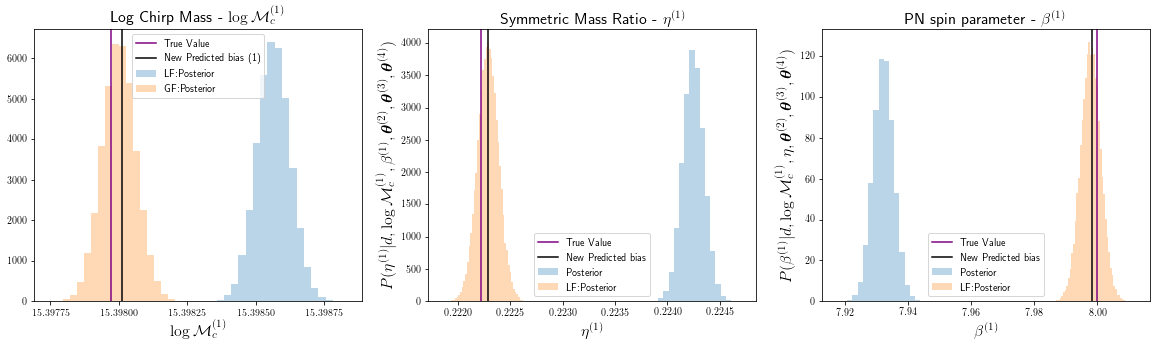

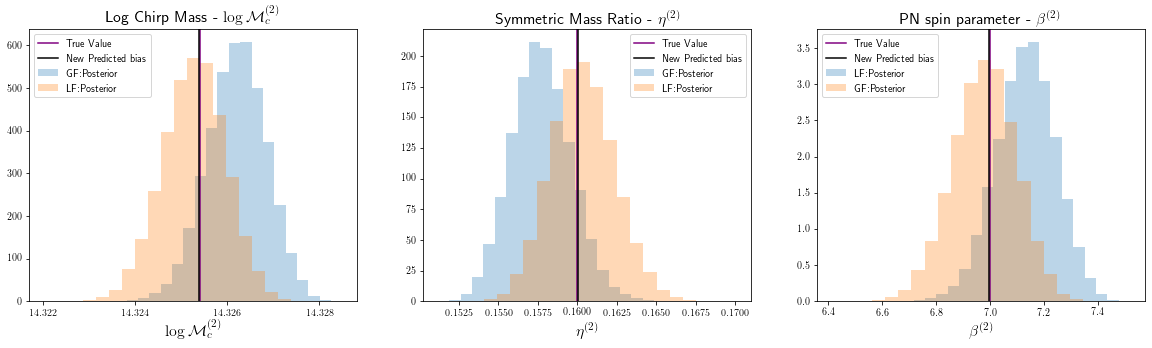

In [35]:
# Results

fig,ax = plt.subplots(1,3,figsize = (20,5))
alpha_val = 0.3

ax[0].hist(logM_chirp_1_samps_A_g_B,density=True,bins = 20,alpha = alpha_val,label = 'LF:Posterior')
ax[0].hist(logM_chirp_1_samps,density=True,bins = 20,alpha = alpha_val,label = 'GF:Posterior')
ax[0].axvline(x = np.log(M_chirp_1),color = 'purple',  label = 'True Value')
# ax[0].axvline(x = np.log(M_chirp_1) + biases_pred_unresolved_A_bf[0],c = 'green',label = 'Unresolved  signal bias' )
ax[0].axvline(x = np.mean(logM_chirp_1_samps_A_g_B) - new_biases_A_g_B_0[0], color = 'k', label = 'New Predicted bias (1)')
# ax[0].axvline(x = pars_A_g_B_res_2[0], color = 'blue', label = 'New Predicted bias (2)')
ax[0].set_xlabel(r'$\log \mathcal{M}^{(1)}_{c}$',fontsize = 16)
# ax[0].set_ylabel(r'$P(\log \mathcal{M}^{(1)}_{c}|d,\eta^{(1)},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[0].set_title(r'Log Chirp Mass - $\log \mathcal{M}^{(1)}_{c}$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[0].locator_params(axis='x', nbins=5)
ax[0].legend()
# ax[0].show()



ax[1].hist(eta_1_samps_A_g_B,density=True,bins = 50,alpha = alpha_val,label = 'Posterior')
ax[1].hist(eta_1_samps,density=True,bins = 50,alpha = alpha_val,label = 'LF:Posterior')
ax[1].axvline(x = eta_1,c = 'purple', label = 'True Value')
# ax[1].axvline(x = eta_1 + biases_pred_unresolved_A_bf[1],c = 'green',label = 'Unresolved signal bias' )
ax[1].axvline(x = np.mean(eta_1_samps_A_g_B) - new_biases_A_g_B_0[1], color = 'k', label = 'New Predicted bias')
# ax[1].axvline(x = pars_A_g_B_res_2[1], color = 'blue', label = 'New Predicted bias (2)')
ax[1].set_xlabel(r'$\eta^{(1)}$',fontsize = 16)
ax[1].set_ylabel(r'$P(\eta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[1].set_title(r'Symmetric Mass Ratio - $\eta^{(1)}$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[1].legend()
# ax[1].show()


ax[2].hist(beta_1_samps_A_g_B,density=True,bins = 50,alpha = alpha_val,label = 'Posterior')
ax[2].hist(beta_1_samps,density=True,bins = 50,alpha = alpha_val,label = 'LF:Posterior')
ax[2].axvline(x = beta_1,c = 'purple', label = 'True Value')
# ax[2].axvline(x = beta_1 + biases_pred_unresolved_A_bf[2],c = 'green',label = 'Unresolved signal bias' )
ax[2].axvline(x = np.mean(beta_1_samps_A_g_B) - new_biases_A_g_B_0[2], color = 'k', label = 'New Predicted bias')
# ax[2].axvline(x = pars_A_g_B_res_2[2], color = 'blue', label = 'New Predicted bias (2)')
ax[2].set_xlabel(r'$\beta^{(1)}$',fontsize = 16)
ax[2].set_ylabel(r'$P(\beta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\eta,\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[2].set_title(r'PN spin parameter - $\beta^{(1)}$',fontsize = 16)
ax[2].legend()




# Results

fig,ax = plt.subplots(1,3,figsize = (20,5))
alpha_val = 0.3

ax[0].hist(logM_chirp_2_samps_B_A_res,density=True,bins = 20,alpha = alpha_val,label = 'GF:Posterior')
ax[0].hist(logM_chirp_2_samps,density=True,bins = 20,alpha = alpha_val,label = 'LF:Posterior')
ax[0].axvline(x = np.log(M_chirp_2) ,color = 'purple',  label = 'True Value')
# ax[0].axvline(x = np.log(M_chirp_2) + biases_pred_unresolved_B_bf[0],c = 'green',label = 'Unresolved  signal bias' )
ax[0].axvline(x = np.mean(logM_chirp_2_samps_B_A_res) - new_biases_B_g_A_0[0], color = 'k', label = 'New Predicted bias')
# ax[0].axvline(x = biases_B_g_A_res_2[0], color = 'blue', label = 'New Predicted bias after iteration')
ax[0].set_xlabel(r'$\log \mathcal{M}^{(2)}_{c}$',fontsize = 16)
# ax[0].set_ylabel(r'$P(\log \mathcal{M}^{(1)}_{c}|d,\eta^{(1)},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[0].set_title(r'Log Chirp Mass - $\log \mathcal{M}^{(2)}_{c}$',fontsize = 16)
# ax[0].set_xlim([np.log(M_chirp_3) - 10*np.sqrt(Cov_Matrix_half_2_bf[0,0]),np.log(M_chirp_3) + 5*np.sqrt(Cov_Matrix_half_2_bf[0,0])])
ax[0].locator_params(axis='x', nbins=5)
ax[0].legend()
# ax[0].show()



ax[1].hist(eta_2_samps_B_A_res,density=True,bins = 20,alpha = alpha_val,label = 'GF:Posterior')
ax[1].hist(eta_2_samps,density=True,bins = 20,alpha = alpha_val,label = 'LF:Posterior')
ax[1].axvline(x = eta_2,c = 'purple', label = 'True Value')
# ax[1].axvline(x = eta_2 + biases_pred_unresolved_B_bf[1],c = 'green',label = 'Unresolved signal bias' )
ax[1].axvline(x = np.mean(eta_2_samps_B_A_res) - new_biases_B_g_A_0[1], color = 'k', label = 'New Predicted bias')
# ax[1].axvline(x = biases_B_g_A_res_2[1], color = 'blue', label = 'New Predicted bias after iteration')
ax[1].set_xlabel(r'$\eta^{(2)}$',fontsize = 16)
# ax[1].set_ylabel(r'$P(\eta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[1].set_title(r'Symmetric Mass Ratio - $\eta^{(2)}$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[1].legend()
# ax[1].show()


ax[2].hist(beta_2_samps_B_A_res,density=True,bins = 20,alpha = alpha_val,label = 'LF:Posterior')
ax[2].hist(beta_2_samps,density=True,bins = 20,alpha = alpha_val,label = 'GF:Posterior')
ax[2].axvline(x = beta_2,c = 'purple', label = 'True Value')
# ax[2].axvline(x = beta_2 + biases_pred_unresolved_B_bf[2],c = 'green',label = 'Unresolved signal bias' )
ax[2].axvline(x = np.mean(beta_2_samps_B_A_res) - new_biases_B_g_A_0[2], color = 'k', label = 'New Predicted bias')
# ax[2].axvline(x = biases_B_g_A_res_2[2], color = 'blue', label = 'New Predicted bias after iteration')
ax[2].set_xlabel(r'$\beta^{(2)}$',fontsize = 16)
# ax[2].set_ylabel(r'$P(\beta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\eta,\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[2].set_title(r'PN spin parameter - $\beta^{(2)}$',fontsize = 16)
ax[2].legend()





print(np.sqrt(np.var(beta_2_samps_B_A_res)),np.sqrt(np.var(beta_2_samps)))






In [36]:
print(np.sqrt(np.var(beta_2_samps_B_A_res)))
print(np.sqrt(np.var(beta_2_samps)))

0.10993953001017757
0.11712246658934558


In [37]:
# Automate

N_iterations = 200

# Initial values

pars_A_g_B_0 = [logM_chirp_1_samps_mean , eta_1_samps_mean, beta_1_samps_mean,Deff_1]
pars_B_g_A_res_0 = [logM_chirp_2_samps_mean  , eta_2_samps_mean, beta_2_samps_mean,Deff_2]

parsA_g_B = [pars_A_g_B_0]
parsB_g_A_res = [pars_B_g_A_res_0]

SNR_A_g_B = []
SNR_B_g_A_res = []
check_biases_A_g_B = []
check_biases_B_g_A_res = []
n =  0
for n in range(0,N_iterations):
    # Step 1 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # Parameters A|B
    
    diff_vec_A_g_B = MS_func.numerical_derivs(freq_bin,parsA_g_B[n])  # Compute numerical derivative
    Cov_Matrix_A_g_B = MS_func.fish_matrix(diff_vec_A_g_B,PSD,delta_f)

    #     print('Cov_Matrix:',np.diag(Cov_Matrix_A_g_B))
    
    # Calculate residual left in A|B

    deltaH_A_g_B = MS_func.htilde_AP(freq_bin,parsB_g_A_res[n])  # Signal B left in data at new params
    deltah_A_g_B = deltaH_A_g_B #+ noise_f
    
    SNR_A_g_B.append(np.sqrt(MS_func.inner_prod(deltah_A_g_B,deltaH_A_g_B,PSD,delta_f))) # Check SNR

    b_vec_unresolved_signals_A_g_B = [MS_func.inner_prod(diff_vec_A_g_B[i],deltaH_A_g_B,
                                                         PSD,delta_f) for i in range(0,3)]
    new_biases_unresolved_signals_A_g_B = np.matmul(Cov_Matrix_A_g_B,
                                                    b_vec_unresolved_signals_A_g_B) # Compute biases
    check_biases_A_g_B.append(new_biases_unresolved_signals_A_g_B)


    # CONTROVERSIAL STEP - Biases subtracted from the Best fit prametrs for A_g_B. 
    # Here pars_A_g_B_0 is fixed and never changes. 
    
    new_pars_A_g_B = list(np.array(pars_A_g_B_0) - np.pad(new_biases_unresolved_signals_A_g_B,(0,1),'constant'))

    parsA_g_B.append(new_pars_A_g_B)

    # Step 2 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    # Parameters B|A

    diff_vec_B_g_A_res = MS_func.numerical_derivs(freq_bin,parsB_g_A_res[n])  

    Cov_Matrix_B_g_A_res = MS_func.fish_matrix(diff_vec_B_g_A_res,PSD,delta_f)

    # Calculate residual in data stream B|A_res with params (used previously in step 1.)

    deltaH_B_g_A_res = MS_func.htilde_AP(freq_bin,parsA_g_B[n+1]) -  MS_func.htilde_AP(freq_bin,parsA_g_B[n])
    deltah_B_g_A_res = deltaH_B_g_A_res# + noise_f
    SNR_B_g_A_res.append(np.sqrt(MS_func.inner_prod(deltaH_B_g_A_res,deltaH_B_g_A_res,PSD,delta_f)))

    b_vec_unresolved_signals_B_g_A_res = [MS_func.inner_prod(diff_vec_B_g_A_res[i],deltah_B_g_A_res,PSD,delta_f) for i in range(0,3)]

    new_biases_unresolved_signals_B_g_A_res = np.matmul(Cov_Matrix_B_g_A_res,
                                                    b_vec_unresolved_signals_B_g_A_res)

    # CONTROVERSIAL STEP - Biases subtracted from best fit parameters for B_g_A.
    # Here the parameters change [I use the previous ones]. Different from step 1 where nothing changes.
    new_pars_B_g_A_res = list(np.array(parsB_g_A_res[n]) -  np.pad(new_biases_unresolved_signals_B_g_A_res,(0,1),'constant'))
    parsB_g_A_res.append(new_pars_B_g_A_res)


In [38]:
# plt.plot(check_biases,'*')
# plt.yscale('log')
# plt.plot(SNR_A_g_B)

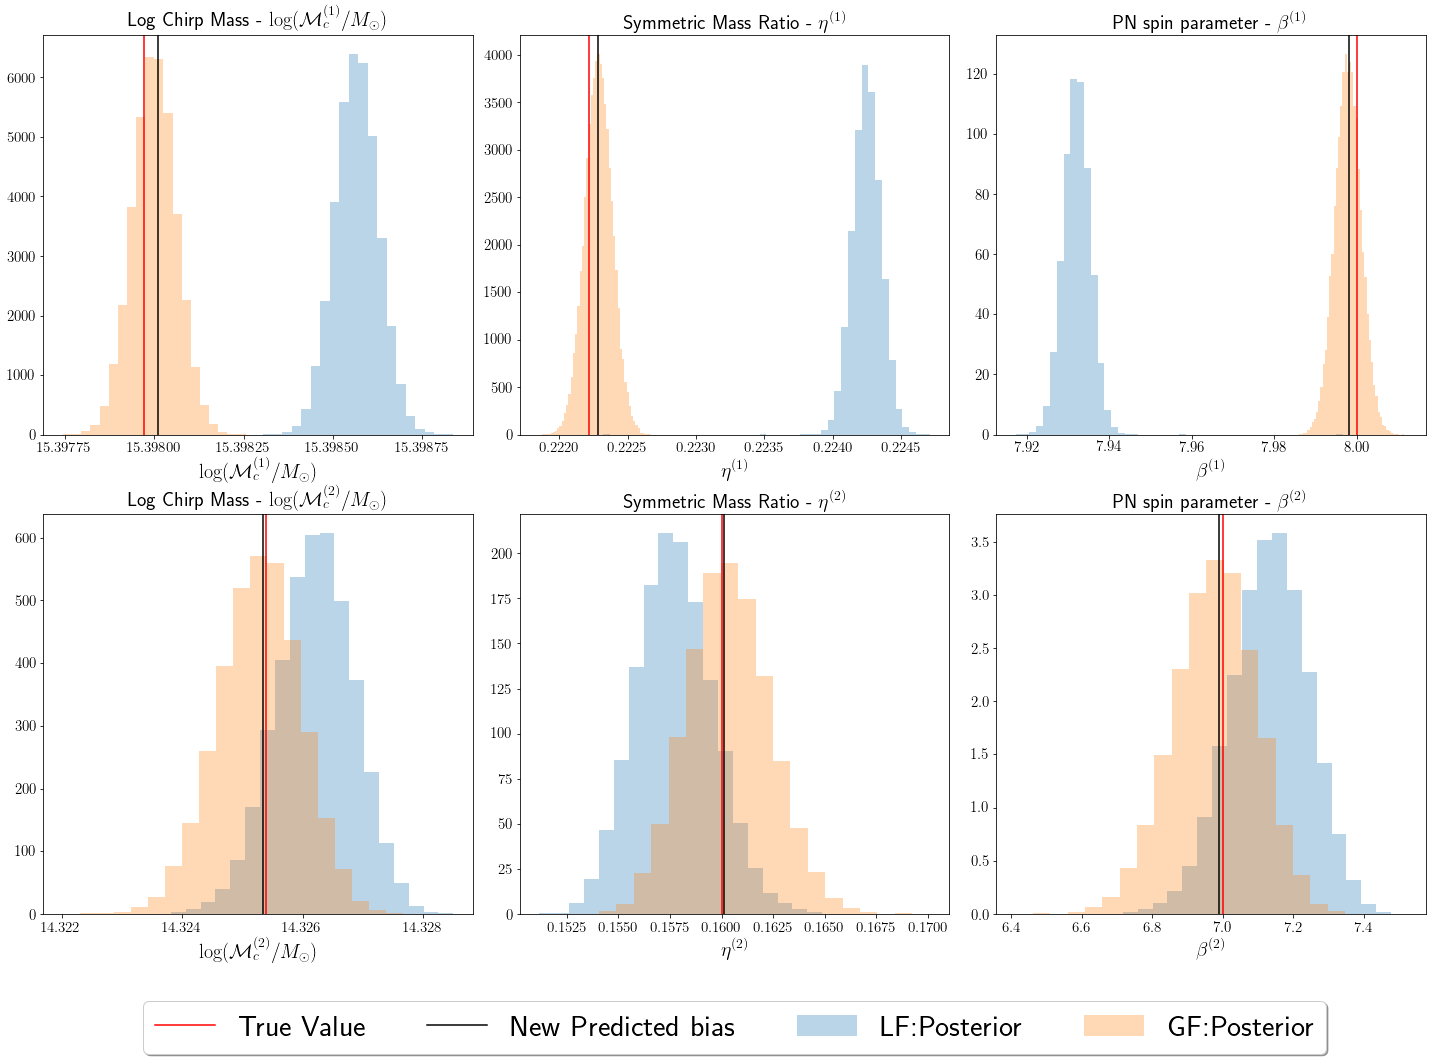

In [46]:
# Results

interation_no = 1

fig,ax = plt.subplots(2,3,figsize = (20,15))
alpha_val = 0.3
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

ax[0][0].hist(logM_chirp_1_samps_A_g_B,density=True,bins = 20,alpha = alpha_val,label = 'Posterior')
ax[0][0].hist(logM_chirp_1_samps,density=True,bins = 20, alpha = alpha_val, label = 'GF:Posterior')
ax[0][0].axvline(x = np.log(M_chirp_1),color = 'red',  label = 'True Value')
# ax[0].axvline(x = np.log(M_chirp_1) + biases_pred_unresolved_A_bf[0],c = 'green',label = 'Unresolved  signal bias' )
ax[0][0].axvline(x = parsA_g_B[interation_no][0], color = 'black', label = 'iteration {}, New Predicted bias'.format(interation_no))
ax[0][0].set_xlabel(r'$\log (\mathcal{M}^{(1)}_{c}/M_{\odot})$',fontsize = 20)
# ax[0].set_ylabel(r'$P(\log \mathcal{M}^{(1)}_{c}|d,\eta^{(1)},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[0][0].set_title(r'Log Chirp Mass - $\log (\mathcal{M}^{(1)}_{c}/M_{\odot})$',fontsize = 20)

ax[0][0].locator_params(axis='x', nbins=5)

# ax[0].show()



ax[0][1].hist(eta_1_samps_A_g_B,bins = 50,density=True,alpha = alpha_val,label = 'LF:Posterior')
ax[0][1].hist(eta_1_samps,bins = 50, density=True, alpha = alpha_val, label = 'GF:Posterior')
ax[0][1].axvline(x = eta_1,c = 'red', label = 'True Value')
# ax[1].axvline(x = eta_1 + biases_pred_unresolved_A_bf[1],c = 'green',label = 'Unresolved signal bias' )
ax[0][1].axvline(x = parsA_g_B[interation_no][1], color = 'black')
ax[0][1].set_xlabel(r'$\eta^{(1)}$',fontsize = 20)
# ax[0][1].set_ylabel(r'$P(\eta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[0][1].set_title(r'Symmetric Mass Ratio - $\eta^{(1)}$',fontsize = 20)
# plt.xlim([1.794,1.803])

# ax[1].show()


ax[0][2].hist(beta_1_samps_A_g_B,bins = 50,density=True,alpha = alpha_val,label = 'Posterior')
ax[0][2].hist(beta_1_samps,bins = 50,density=True,alpha = alpha_val, label = 'GF:Posterior')
ax[0][2].axvline(x = beta_1,c = 'red', label = 'True Value')
# ax[2].axvline(x = beta_1 + biases_pred_unresolved_A_bf[2],c = 'green',label = 'Unresolved signal bias' )
ax[0][2].axvline(x = parsA_g_B[interation_no][2], color = 'black', label = 'iteration {}, New Predicted bias'.format(interation_no))
ax[0][2].set_xlabel(r'$\beta^{(1)}$',fontsize = 20)
# ax[0][2].set_ylabel(r'$P(\beta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\eta,\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[0][2].set_title(r'PN spin parameter - $\beta^{(1)}$',fontsize = 20)





ax[1][0].hist(logM_chirp_2_samps_B_A_res,density=True,bins = 20,alpha = alpha_val,label = 'LF:Posterior')
ax[1][0].hist(logM_chirp_2_samps,density=True,bins = 20,alpha = alpha_val, label = 'GF:Posterior')
ax[1][0].axvline(x = np.log(M_chirp_2) ,color = 'red',  label = 'True Value')
# ax[0].axvline(x = np.log(M_chirp_2) + biases_pred_unresolved_B_bf[0],c = 'green',label = 'Unresolved  signal bias' )
ax[1][0].axvline(x = parsB_g_A_res[interation_no][0], color = 'black')
ax[1][0].set_xlabel(r'$\log (\mathcal{M}^{(2)}_{c}/M_{\odot})$',fontsize = 20)
# ax[1][0].set_ylabel(r'$P(\log \mathcal{M}^{(1)}_{c}|d,\eta^{(1)},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[1][0].set_title(r'Log Chirp Mass - $\log (\mathcal{M}^{(2)}_{c}/M_{\odot})$',fontsize = 20)
ax[1][0].locator_params(axis='x', nbins=5)

# ax[0].show()



ax[1][1].hist(eta_2_samps_B_A_res,density=True,bins = 20,alpha = alpha_val,label = 'LF:Posterior')
ax[1][1].hist(eta_2_samps,density=True,bins = 20,alpha = alpha_val, label = 'GF:Posterior')
ax[1][1].axvline(x = eta_2,c = 'red', label = 'True Value')
# ax[1].axvline(x = eta_2 + biases_pred_unresolved_B_bf[1],c = 'green',label = 'Unresolved signal bias' )
ax[1][1].axvline(x = parsB_g_A_res[interation_no][1], color = 'black', label = 'New Predicted bias')
ax[1][1].set_xlabel(r'$\eta^{(2)}$',fontsize = 20)
# ax[1].set_ylabel(r'$P(\eta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[1][1].set_title(r'Symmetric Mass Ratio - $\eta^{(2)}$',fontsize = 20)
# ax[1].set_xlim([0.19,0.245])

# ax[1].show()


ax[1][2].hist(beta_2_samps_B_A_res,density=True,bins = 20,alpha = alpha_val)
ax[1][2].hist(beta_2_samps,density=True,bins = 20,alpha = alpha_val)
ax[1][2].axvline(x = beta_2,c = 'red')
# ax[2].axvline(x = beta_2 + biases_pred_unresolved_B_bf[2],c = 'green',label = 'Unresolved signal bias' )
ax[1][2].axvline(x = parsB_g_A_res[interation_no][2], color = 'black')
ax[1][2].set_xlabel(r'$\beta^{(2)}$',fontsize = 20)
# ax[2].set_ylabel(r'$P(\beta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\eta,\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[1][2].set_title(r'PN spin parameter - $\beta^{(2)}$',fontsize = 20)
plt.tight_layout()

box = ax[1][1].get_position()
# ax[1].set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])

# Put a legend below current axis
ax[1][1].legend(fontsize = 30, loc='upper center', bbox_to_anchor=(0.5, -0.18),
          fancybox=True, shadow=True, ncol=4)

fig.subplots_adjust(bottom=0.15)
 

os.chdir('/Users/Ollie/Documents/GitHub_Repositories/population-systematics/Codes/OB/GW_Sources/TaylorF2_Examples/Exploring_Formalism/LISA_Explore/Global_Fit_Realistic/plots')
plt.savefig("GF_noise_waveform_eps_1e-3.pdf")





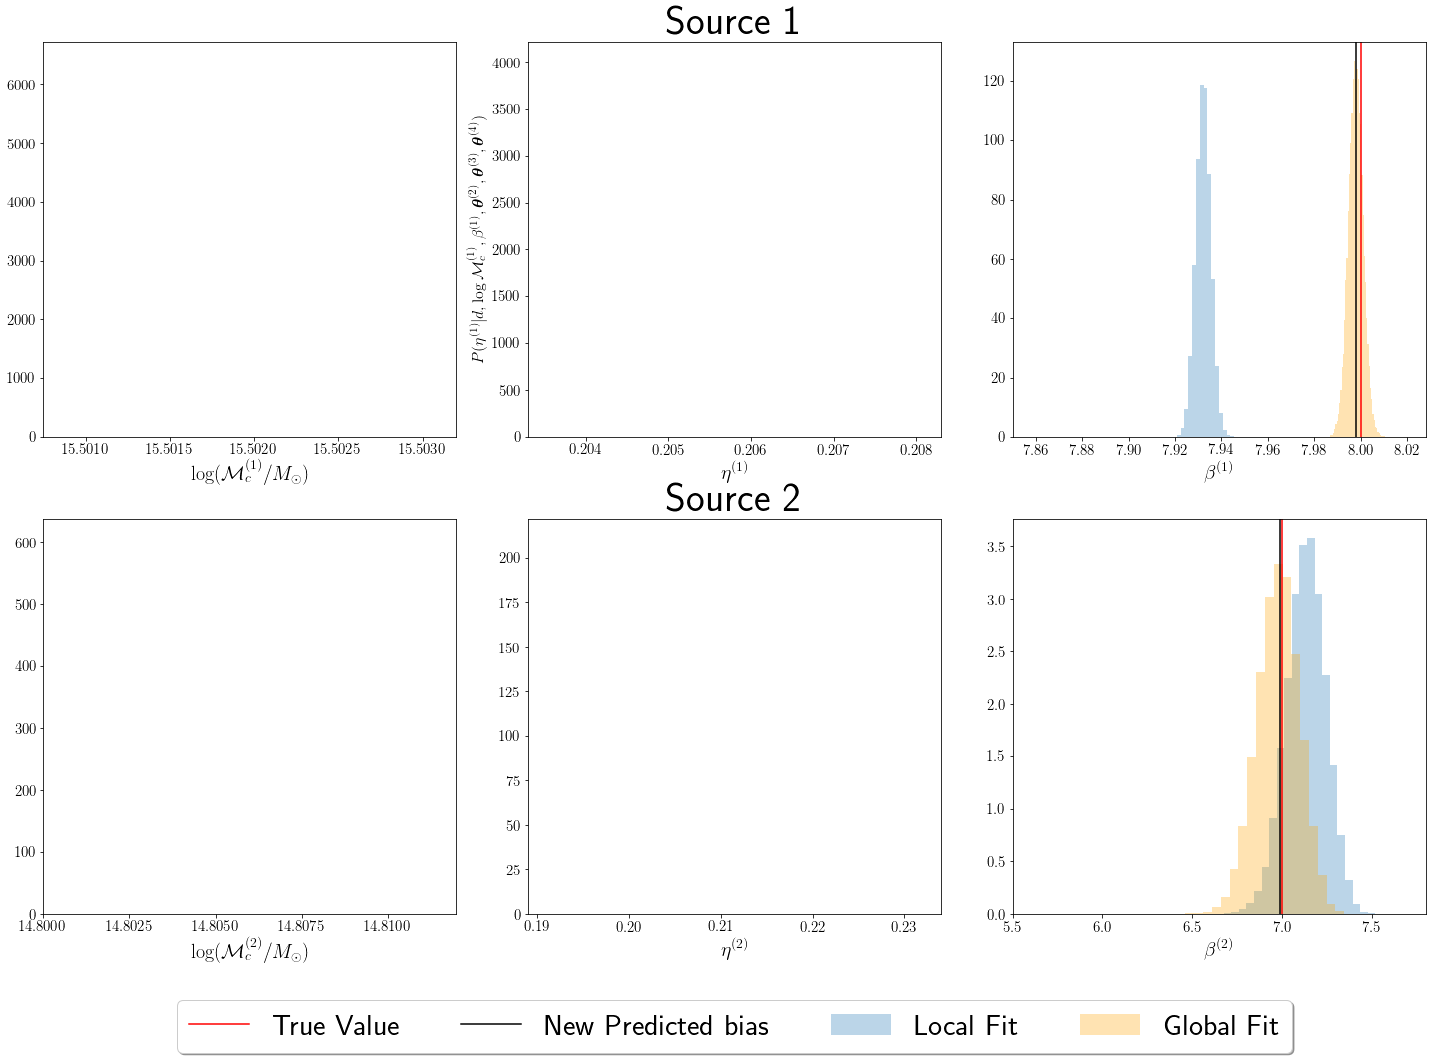

In [40]:
# Results - Presentation

interation_no = 1

fig,ax = plt.subplots(2,3,figsize = (20,15))
alpha_val = 0.3
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

ax[0][0].hist(logM_chirp_1_samps_A_g_B,density=True,bins = 20,alpha = alpha_val)
ax[0][0].hist(logM_chirp_1_samps,density=True,bins = 20, color = 'orange',alpha = alpha_val)
ax[0][0].axvline(x = np.log(M_chirp_1),color = 'red',  label = 'True Value')
# ax[0].axvline(x = np.log(M_chirp_1) + biases_pred_unresolved_A_bf[0],c = 'green',label = 'Unresolved  signal bias' )
ax[0][0].axvline(x = parsA_g_B[interation_no][0], color = 'black', label = 'iteration {}, New Predicted bias'.format(interation_no))
ax[0][0].set_xlabel(r'$\log (\mathcal{M}^{(1)}_{c}/M_{\odot})$',fontsize = 20)
# ax[0].set_ylabel(r'$P(\log \mathcal{M}^{(1)}_{c}|d,\eta^{(1)},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[0][0].set_xlim([15.50075,15.5032])
ax[0][0].locator_params(axis='x', nbins=5)

# ax[0].show()



ax[0][1].hist(eta_1_samps_A_g_B,bins = 50,density=True,alpha = alpha_val)
ax[0][1].hist(eta_1_samps,bins = 50, density=True, alpha = alpha_val, color = 'orange')
ax[0][1].axvline(x = eta_1,c = 'red', label = 'True Value')
# ax[1].axvline(x = eta_1 + biases_pred_unresolved_A_bf[1],c = 'green',label = 'Unresolved signal bias' )
ax[0][1].axvline(x = parsA_g_B[interation_no][1], color = 'black')
ax[0][1].set_xlabel(r'$\eta^{(1)}$',fontsize = 20)
ax[0][1].set_ylabel(r'$P(\eta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[0][1].set_title(r'Source 1',fontsize = 40)
ax[0][1].set_xlim([0.2033,0.2083])
# plt.xlim([1.794,1.803])

# ax[1].show()


ax[0][2].hist(beta_1_samps_A_g_B,bins = 50,density=True,alpha = alpha_val)
ax[0][2].hist(beta_1_samps,bins = 50,density=True,alpha = alpha_val, color = 'orange')
ax[0][2].axvline(x = beta_1,c = 'red', label = 'True Value')
# ax[2].axvline(x = beta_1 + biases_pred_unresolved_A_bf[2],c = 'green',label = 'Unresolved signal bias' )
ax[0][2].axvline(x = parsA_g_B[interation_no][2], color = 'black', label = 'iteration {}, New Predicted bias'.format(interation_no))
ax[0][2].set_xlabel(r'$\beta^{(1)}$',fontsize = 20)
# ax[0][2].set_ylabel(r'$P(\beta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\eta,\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[0][2].set_xlim([7.850,8.028])




ax[1][0].hist(logM_chirp_2_samps_B_A_res,density=True,bins = 20,alpha = alpha_val)
ax[1][0].hist(logM_chirp_2_samps,density=True,bins = 20,alpha = alpha_val, color = 'orange')
ax[1][0].axvline(x = np.log(M_chirp_2) ,color = 'red',  label = 'True Value')
# ax[0].axvline(x = np.log(M_chirp_2) + biases_pred_unresolved_B_bf[0],c = 'green',label = 'Unresolved  signal bias' )
ax[1][0].axvline(x = parsB_g_A_res[interation_no][0], color = 'black')
ax[1][0].set_xlabel(r'$\log (\mathcal{M}^{(2)}_{c}/M_{\odot})$',fontsize = 20)
#ax[1][0].set_ylabel(r'$P(\log \mathcal{M}^{(1)}_{c}|d,\eta^{(1)},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[1][0].locator_params(axis='x', nbins=5)
ax[1][0].set_xlim([14.800,14.812])

# ax[0].show()



ax[1][1].hist(eta_2_samps_B_A_res,density=True,bins = 20,alpha = alpha_val, label = 'Local Fit')
ax[1][1].hist(eta_2_samps,density=True,bins = 20,alpha = alpha_val, label = 'Global Fit', color = 'orange')
ax[1][1].axvline(x = eta_2,c = 'red', label = 'True Value')
# ax[1].axvline(x = eta_2 + biases_pred_unresolved_B_bf[1],c = 'green',label = 'Unresolved signal bias' )
ax[1][1].axvline(x = parsB_g_A_res[interation_no][1], color = 'black', label = 'New Predicted bias')
ax[1][1].set_xlabel(r'$\eta^{(2)}$',fontsize = 20)
# ax[1].set_ylabel(r'$P(\eta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[1][1].set_title(r'Source 2',fontsize = 40)
ax[1][1].set_xlim([0.189,0.234])

# ax[1].show()


ax[1][2].hist(beta_2_samps_B_A_res,density=True,bins = 20,alpha = alpha_val)
ax[1][2].hist(beta_2_samps,density=True,bins = 20,alpha = alpha_val, color = 'orange')
ax[1][2].axvline(x = beta_2,c = 'red')
# ax[2].axvline(x = beta_2 + biases_pred_unresolved_B_bf[2],c = 'green',label = 'Unresolved signal bias' )
ax[1][2].axvline(x = parsB_g_A_res[interation_no][2], color = 'black')
ax[1][2].set_xlabel(r'$\beta^{(2)}$',fontsize = 20)
# ax[2].set_ylabel(r'$P(\beta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\eta,\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[1][2].set_xlim([5.5,7.8])
plt.tight_layout()

box = ax[1][1].get_position()
# ax[1].set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])

# Put a legend below current axis
ax[1][1].legend(fontsize = 30, loc='upper center', bbox_to_anchor=(0.5, -0.18),
          fancybox=True, shadow=True, ncol=4)

fig.subplots_adjust(bottom=0.15)
 

# os.chdir('/Users/Ollie/Documents/GitHub_Repositories/population-systematics/Codes/OB/GW_Sources/TaylorF2_Examples/Exploring_Formalism/LISA_Explore/Global_Fit_Realistic/plots')
# plt.savefig("GF_noise_waveform_plot_presentation_3.jpg")






In [41]:
# Automate

N_iterations = 100

# Initial values

pars_A_g_B_0 = [logM_chirp_1_samps_mean , eta_1_samps_mean, beta_1_samps_mean,Deff_1]
pars_B_g_A_res_0 = [logM_chirp_2_samps_mean  , eta_2_samps_mean, beta_2_samps_mean,Deff_2]

parsA_g_B = [pars_A_g_B_0]
parsB_g_A_res = [pars_B_g_A_res_0]

SNR_A_g_B = []
SNR_B_g_A_res = []
check_biases_A_g_B = []
check_biases_B_g_A_res = []
n =  0
for n in range(0,N_iterations):
    # Step 1 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # Parameters A|B
    
    diff_vec_A_g_B = MS_func.numerical_derivs(freq_bin,parsA_g_B[n])  # Compute numerical derivative
    Cov_Matrix_A_g_B = MS_func.fish_matrix(diff_vec_A_g_B,PSD,delta_f)

    #     print('Cov_Matrix:',np.diag(Cov_Matrix_A_g_B))
    
    # Calculate residual left in A|B

    deltaH_A_g_B = MS_func.htilde_AP(freq_bin,parsB_g_A_res[n])  # Signal B left in data at new params
    deltah_A_g_B = deltaH_A_g_B #+ noise_f
    
    SNR_A_g_B.append(np.sqrt(MS_func.inner_prod(deltah_A_g_B,deltaH_A_g_B,PSD,delta_f))) # Check SNR

    b_vec_unresolved_signals_A_g_B = [MS_func.inner_prod(diff_vec_A_g_B[i],deltaH_A_g_B,
                                                         PSD,delta_f) for i in range(0,3)]
    new_biases_unresolved_signals_A_g_B = np.matmul(Cov_Matrix_A_g_B,
                                                    b_vec_unresolved_signals_A_g_B) # Compute biases
    check_biases_A_g_B.append(new_biases_unresolved_signals_A_g_B)


    # CONTROVERSIAL STEP - Biases subtracted from the Best fit prametrs for A_g_B. 
    # Here pars_A_g_B_0 is fixed and never changes. 
    
    new_pars_A_g_B = list(np.array(parsA_g_B[n]) - np.pad(new_biases_unresolved_signals_A_g_B,(0,1),'constant'))

    parsA_g_B.append(new_pars_A_g_B)

    # Step 2 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    # Parameters B|A

    diff_vec_B_g_A_res = MS_func.numerical_derivs(freq_bin,parsB_g_A_res[n])  

    Cov_Matrix_B_g_A_res = MS_func.fish_matrix(diff_vec_B_g_A_res,PSD,delta_f)

    # Calculate residual in data stream B|A_res with params (used previously in step 1.)

    deltaH_B_g_A_res = MS_func.htilde_AP(freq_bin,parsA_g_B[n+1]) -  MS_func.htilde_AP(freq_bin,parsA_g_B[n])
    deltah_B_g_A_res = deltaH_B_g_A_res #+ noise_f
    SNR_B_g_A_res.append(np.sqrt(MS_func.inner_prod(deltaH_B_g_A_res,deltaH_B_g_A_res,PSD,delta_f)))

    b_vec_unresolved_signals_B_g_A_res = [MS_func.inner_prod(diff_vec_B_g_A_res[i],deltah_B_g_A_res,PSD,delta_f) for i in range(0,3)]

    new_biases_unresolved_signals_B_g_A_res = np.matmul(Cov_Matrix_B_g_A_res,
                                                    b_vec_unresolved_signals_B_g_A_res)

    # CONTROVERSIAL STEP - Biases subtracted from best fit parameters for B_g_A.
    # Here the parameters change [I use the previous ones]. Different from step 1 where nothing changes.
    new_pars_B_g_A_res = list(np.array(parsB_g_A_res[n]) -  np.pad(new_biases_unresolved_signals_B_g_A_res,(0,1),'constant'))
    parsB_g_A_res.append(new_pars_B_g_A_res)



for B_A_res, SD: 0.10993953001017757
for B global fit, SD: 0.11712246658934558
0.012028820179070825


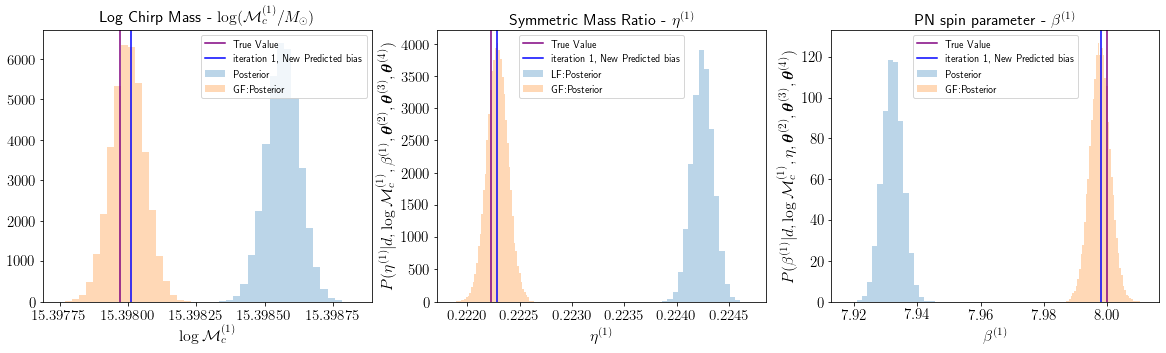

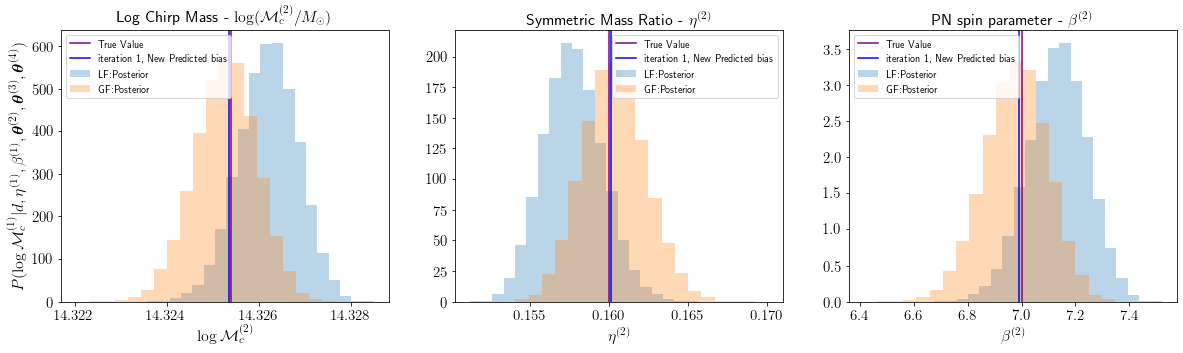

In [42]:
# Results - Using what I believe to be the right algorithm.

interation_no = 1

fig,ax = plt.subplots(1,3,figsize = (20,5))
alpha_val = 0.3

ax[0].hist(logM_chirp_1_samps_A_g_B,density=True,bins = 20,alpha = alpha_val,label = 'Posterior')
ax[0].hist(logM_chirp_1_samps,density=True,bins = 20, alpha = alpha_val, label = 'GF:Posterior')
ax[0].axvline(x = np.log(M_chirp_1),color = 'purple',  label = 'True Value')
# ax[0].axvline(x = np.log(M_chirp_1) + biases_pred_unresolved_A_bf[0],c = 'green',label = 'Unresolved  signal bias' )
ax[0].axvline(x = parsA_g_B[interation_no][0], color = 'blue', label = 'iteration {}, New Predicted bias'.format(interation_no))
ax[0].set_xlabel(r'$\log \mathcal{M}^{(1)}_{c}$',fontsize = 16)
# ax[0].set_ylabel(r'$P(\log \mathcal{M}^{(1)}_{c}|d,\eta^{(1)},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[0].set_title(r'Log Chirp Mass - $\log (\mathcal{M}^{(1)}_{c}/M_{\odot})$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[0].locator_params(axis='x', nbins=5)
ax[0].legend()
# ax[0].show()



ax[1].hist(eta_1_samps_A_g_B,bins = 50,density=True,alpha = alpha_val,label = 'LF:Posterior')
ax[1].hist(eta_1_samps,bins = 50, density=True, alpha = alpha_val, label = 'GF:Posterior')
ax[1].axvline(x = eta_1,c = 'purple', label = 'True Value')
# ax[1].axvline(x = eta_1 + biases_pred_unresolved_A_bf[1],c = 'green',label = 'Unresolved signal bias' )
ax[1].axvline(x = parsA_g_B[interation_no][1], color = 'blue', label = 'iteration {}, New Predicted bias'.format(interation_no))
ax[1].set_xlabel(r'$\eta^{(1)}$',fontsize = 16)
ax[1].set_ylabel(r'$P(\eta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[1].set_title(r'Symmetric Mass Ratio - $\eta^{(1)}$',fontsize = 16)
# plt.xlim([1.794,1.803])
ax[1].legend()
# ax[1].show()


ax[2].hist(beta_1_samps_A_g_B,bins = 50,density=True,alpha = alpha_val,label = 'Posterior')
ax[2].hist(beta_1_samps,bins = 50,density=True,alpha = alpha_val, label = 'GF:Posterior')
ax[2].axvline(x = beta_1,c = 'purple', label = 'True Value')
# ax[2].axvline(x = beta_1 + biases_pred_unresolved_A_bf[2],c = 'green',label = 'Unresolved signal bias' )
ax[2].axvline(x = parsA_g_B[interation_no][2], color = 'blue', label = 'iteration {}, New Predicted bias'.format(interation_no))
ax[2].set_xlabel(r'$\beta^{(1)}$',fontsize = 16)
ax[2].set_ylabel(r'$P(\beta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\eta,\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[2].set_title(r'PN spin parameter - $\beta^{(1)}$',fontsize = 16)
ax[2].legend()




# Results

fig,ax = plt.subplots(1,3,figsize = (20,5))
alpha_val = 0.3

ax[0].hist(logM_chirp_2_samps_B_A_res,density=True,bins = 20,alpha = alpha_val,label = 'LF:Posterior')
ax[0].hist(logM_chirp_2_samps,density=True,bins = 20,alpha = alpha_val, label = 'GF:Posterior')
ax[0].axvline(x = np.log(M_chirp_2) ,color = 'purple',  label = 'True Value')
# ax[0].axvline(x = np.log(M_chirp_2) + biases_pred_unresolved_B_bf[0],c = 'green',label = 'Unresolved  signal bias' )
ax[0].axvline(x = parsB_g_A_res[interation_no][0], color = 'blue', label = 'iteration {}, New Predicted bias'.format(interation_no))
ax[0].set_xlabel(r'$\log \mathcal{M}^{(2)}_{c}$',fontsize = 16)
ax[0].set_ylabel(r'$P(\log \mathcal{M}^{(1)}_{c}|d,\eta^{(1)},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[0].set_title(r'Log Chirp Mass - $\log (\mathcal{M}^{(2)}_{c}/M_{\odot})$',fontsize = 16)
ax[0].locator_params(axis='x', nbins=5)
ax[0].legend()
# ax[0].show()



ax[1].hist(eta_2_samps_B_A_res,density=True,bins = 20,alpha = alpha_val,label = 'LF:Posterior')
ax[1].hist(eta_2_samps,density=True,bins = 20,alpha = alpha_val, label = 'GF:Posterior')
ax[1].axvline(x = eta_2,c = 'purple', label = 'True Value')
# ax[1].axvline(x = eta_2 + biases_pred_unresolved_B_bf[1],c = 'green',label = 'Unresolved signal bias' )
ax[1].axvline(x = parsB_g_A_res[interation_no][1], color = 'blue', label = 'iteration {}, New Predicted bias'.format(interation_no))
ax[1].set_xlabel(r'$\eta^{(2)}$',fontsize = 16)
# ax[1].set_ylabel(r'$P(\eta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\beta^{(1)},\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[1].set_title(r'Symmetric Mass Ratio - $\eta^{(2)}$',fontsize = 16)
# ax[1].set_xlim([0.19,0.245])
ax[1].legend()
# ax[1].show()


ax[2].hist(beta_2_samps_B_A_res,density=True,bins = 20,alpha = alpha_val,label = 'LF:Posterior')
ax[2].hist(beta_2_samps,density=True,bins = 20,alpha = alpha_val, label = 'GF:Posterior')
ax[2].axvline(x = beta_2,c = 'purple', label = 'True Value')
# ax[2].axvline(x = beta_2 + biases_pred_unresolved_B_bf[2],c = 'green',label = 'Unresolved signal bias' )
ax[2].axvline(x = parsB_g_A_res[interation_no][2], color = 'blue', label = 'iteration {}, New Predicted bias'.format(interation_no))
ax[2].set_xlabel(r'$\beta^{(2)}$',fontsize = 16)
# ax[2].set_ylabel(r'$P(\beta^{(1)}|d,\log \mathcal{M}^{(1)}_{c},\eta,\boldsymbol{\theta}^{(2)},\boldsymbol{\theta}^{(3)},\boldsymbol{\theta}^{(4)})$',fontsize = 16)
ax[2].set_title(r'PN spin parameter - $\beta^{(2)}$',fontsize = 16)
ax[2].legend()







print('for B_A_res, SD:',np.sqrt(np.var(beta_2_samps_B_A_res)))
print('for B global fit, SD:',np.sqrt(np.var(beta_2_samps)))
print(np.sqrt(Cov_Matrix_B_g_A_res[2,2]))


In [43]:
# Diagnostics

In [44]:
# Comparison:
h_f_1 = MS_func.htilde_GR(freq_bin,eps_GR,pars_1)
h_f_2 = MS_func.htilde_GR(freq_bin,eps_GR,pars_2)



diff_vec_A = MS_func.numerical_derivs(freq_bin,pars_1)
Cov_Matrix_A = MS_func.fish_matrix(diff_vec_A,PSD,delta_f)
        
true_vals_A = [np.log(M_chirp_1),eta_1,beta_1]

D_vec = [Deff_1]
Ntotal = 200000

data_A = h_f_1
        
logM_chirp_A_only,eta_A_only,beta_A_only,lp = MS_func.MCMC_1_sig(data_A,
                                                   freq_bin, true_vals_A,D_vec,Cov_Matrix_A,
                                                   variances,
                                                   logM_chirp_high,logM_chirp_low,
                                                   eta_high,eta_low,
                                                   beta_high,beta_low,
                                                   Ntotal, 
                                                   burnin, 
                                                   printerval = 25000,
                                                   )

diff_vec_B = MS_func.numerical_derivs(freq_bin,pars_2)
Cov_Matrix_B = MS_func.fish_matrix(diff_vec_B,PSD,delta_f)
        
true_vals_B = [np.log(M_chirp_2),eta_2,beta_2]

D_vec = [Deff_2]
Ntotal = 200000

data_B = h_f_2

logM_chirp_B_only,eta_B_only,beta_B_only,lp = MS_func.MCMC_1_sig(data_B,
                                                   freq_bin, true_vals_B,D_vec,Cov_Matrix_B,
                                                   variances,
                                                   logM_chirp_high,logM_chirp_low,
                                                   eta_high,eta_low,
                                                   beta_high,beta_low,
                                                   Ntotal, 
                                                   burnin, 
                                                   printerval = 25000,
                                                   )




Prepare for bias
i =  25000
acceptance_reject ratio 45.484 percent
i =  50000
acceptance_reject ratio 45.268 percent
i =  75000
acceptance_reject ratio 45.284 percent
i =  100000
acceptance_reject ratio 45.245 percent
i =  125000
acceptance_reject ratio 45.2712 percent
i =  150000
acceptance_reject ratio 45.268 percent
i =  175000
acceptance_reject ratio 45.244 percent
Prepare for bias
i =  25000
acceptance_reject ratio 44.104 percent
i =  50000
acceptance_reject ratio 44.114 percent
i =  75000
acceptance_reject ratio 44.148 percent
i =  100000
acceptance_reject ratio 44.052 percent
i =  125000
acceptance_reject ratio 43.98 percent
i =  150000
acceptance_reject ratio 43.980666666666664 percent
i =  175000
acceptance_reject ratio 44.02857142857143 percent


In [45]:

print('Single Analysls')
print('')
print('Source 1')
print('SD M_chirp_A',np.sqrt(np.var(logM_chirp_A_only)))
print('SD eta_A',np.sqrt(np.var(eta_A_only)))
print('SD beta_A',np.sqrt(np.var(beta_A_only)))
print('')
print('Source 2')
print('SD M_chirp_B',np.sqrt(np.var(logM_chirp_B_only)))
print('SD eta_B',np.sqrt(np.var(eta_B_only)))
print('SD beta_B',np.sqrt(np.var(beta_B_only)))
print('')
print('Joint analysis')
print('')

print("Source 1")
print('MCMC logM_chirp:',np.sqrt(np.var(logM_chirp_1_samps)))
print('MCMC eta:',np.sqrt(np.var(eta_1_samps)))
print('MCMC beta:',np.sqrt(np.var(beta_1_samps)))
print('')

print("Source 2")
print('MCMC logM_chirp:',np.sqrt(np.var(logM_chirp_2_samps)))
print('MCMC eta:',np.sqrt(np.var(eta_2_samps)))
print('MCMC beta:',np.sqrt(np.var(beta_2_samps)))

Single Analysls

Source 1
SD M_chirp_A 6.09775853989866e-05
SD eta_A 0.0001008150407428191
SD beta_A 0.0031893246302713133

Source 2
SD M_chirp_B 0.0006576796851949522
SD eta_B 0.0019396178515928017
SD beta_B 0.11334653472193179

Joint analysis

Source 1
MCMC logM_chirp: 6.12318340164017e-05
MCMC eta: 0.0001004858699137552
MCMC beta: 0.0031780164191927474

Source 2
MCMC logM_chirp: 0.0006790637157796048
MCMC eta: 0.0020046103310291715
MCMC beta: 0.11712246658934558
